## Hate Speech Data Collection

We will start from collecting the Hate speech data using FDCL18_100k tweets data containing tweets ID (like 849667487180259329, 850490912954351616, 848791766853668864, ...and so on) and tweets labels (Abusive, hate, normal, and spam).

In [ ]:
import pandas as pd

# Loading Dataset for hate Speech
df = pd.read_csv('/content/hatespeechtwitter.csv')
df

Authentication for twitter API using tweepy package

In [ ]:
import tweepy

# Authenticating the twitter API with secret key
with open ('/content/twitter-api-secret.txt', "r") as api_file:
  api_secret=api_file.read().splitlines() 

auth = tweepy.AppAuthHandler(api_secret[0], api_secret[1])

api = tweepy.API(auth, wait_on_rate_limit=True)

Got all the tweet ids array. Now we can iterate over and get all the tweets.

In [ ]:
# The list contains all the IDs for which corresponding tweets we have to fetch
tweet_IDs_list = df["tweet_id"].values
tweet_IDs_list

array([849667487180259329, 850490912954351616, 848791766853668864, ...,
       848201162717265920, 848939985160077312, 847673586361843713])

In [ ]:
# By this for loop below we will collect the tweet text for the corresponding ID.
df_tweets = pd.DataFrame()
df_tweets['text'] = None
for ids in tweet_IDs_list:
  try:
    tweet = api.get_status(ids)
    df_tweets.at[i,'text'] = tweet.text
    df_tweets.at[i,'label'] =df["maj_label"].iloc[i]
    print(tweet.text)
  except:
    df_tweets.at[i,'text'] ="Nan"
    print("ID is not valid")

ID is not valid
Alex Brosas another idiot #ALDUBKSGoesToUS  https://t.co/14G7hFwVQm
RT @ItIzBiz: as Nancy Reagan would say, 'just say FUCKING NO!"
or something like that... https://t.co/ZaxB2gCq5v
ID is not valid
RT @MailOnline: The Nazi death gas so horrific even Hitler feared using it https://t.co/pO2FiPVcnc
I hate er chase because if the Bitch that works there she's literally evil
ID is not valid
RT @chevleia: don't hmu when u get tired of ur boring hoe ur boring now too
RT @ashllyd: SICK OF BITCHES ON THE INTERNET 🐍🙅👉https://t.co/BkyqCFx64G @UKBloggers1 @FemaleBloggerRT @TheGirlGangHQ #fbloggers #fblchat @U…
ID is not valid
ID is not valid
ID is not valid
RT @nyctophil3: Pineapples do not belong on pizza. Y'all niggas are nasty.
ID is not valid
ID is not valid
ID is not valid
But he still with the shits so he started smoking and drinking (bad combo) probably looking like ... https://t.co/GWLVBxkGgh
RT @Configa: April Fools fucking #dope If you ain't feeling this than you have rigor

In [ ]:
df_tweets.head(20)

text    label
0                                                 Nan      NaN
1   Alex Brosas another idiot #ALDUBKSGoesToUS  ht...  abusive
2   RT @ItIzBiz: as Nancy Reagan would say, 'just ...  abusive
3                                                 Nan      NaN
4   RT @MailOnline: The Nazi death gas so horrific...   normal
5   I hate er chase because if the Bitch that work...  hateful
6                                                 Nan      NaN
7   RT @chevleia: don't hmu when u get tired of ur...  abusive
8   RT @ashllyd: SICK OF BITCHES ON THE INTERNET 🐍...  abusive
9                                                 Nan      NaN
10                                                Nan      NaN
11                                                Nan      NaN
12  RT @nyctophil3: Pineapples do not belong on pi...  hateful
13                                                Nan      NaN
14                                                Nan      NaN
15                                                Nan      NaN
16  But he still with the shits so he started smok...  abusive
17  RT @Configa: April Fools fucking #dope If you ...  abusive
18                                                Nan      NaN
19                                                Nan      NaN

In [ ]:
# Remove the row whoes corresponding tweet is not available anymore. In other words, drop row with NaN value.
df_tweets.dropna(inplace=True)

We have collected 100k tweets for training our 1st model which we named hatespeech model. This will predict, later on, in our pipeline that either tweets are abusive, hateful, normal or spam in nature. We created a dataframe and saved the file using google files package

In [ ]:
df_tweets.rename(columns = {'text':'tweets'}, inplace = True)
df_tweets.to_csv('hatespeech_100k.csv', encoding='utf-8', index=False)

# Save the dataframe into CSV
from google.colab import files
files.download('hatespeech_100k.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Hate Speech Data Preprocessing

Now we will start preprocessing of the hatespeech data and do some EDA.

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [119]:
! pip install spacy --upgrade
! python -m spacy download en_core_web_sm
! pip install textacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-05-08 00:47:16.007082: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 00:47:17.861298: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 41.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 5.1 MB/s eta 0:00:00
    

##Exploratory data analysis (EDA): For Top Stopwords, Punctuation and Emoji Analysis

As Exploratory Data Analysis (EDA) is the process of analyzing and summarizing data in order to gain insights and understand its underlying structure, we are trying to visualize our data so that appropriate cleaning steps can be taken before training the model.

Our data is from the Twitter dataset, which is infamous for containing many emojis, symbols like @ and #, and links in the tweets.

Additionally, other insights will help us to understand our data more clearly, such as which stopwords are mainly used in the tweets and what punctuation people use in their tweets. We also performed other useful EDA like Percentage of Different Labels in the Dataset, Network Graph of Tweet Relationships and Scatter Plot of Tweet Sentiment.

In [120]:
import spacy
from textacy import preprocessing
nlp = spacy.load('en_core_web_sm')
from spacy.tokenizer import Tokenizer
import re
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt

In [ ]:
# Loading dataset of 1000 samples
data_hatespeech = pd.read_csv('/content/hatespeech_100k.csv', encoding='iso-8859-1')
data_hatespeech.head(5)

tweets   labels
0  Beats by Dr. Dre urBeats Wired In-Ear Headphon...     spam
1  RT @Papapishu: Man it would fucking rule if we...  abusive
2  It is time to draw close to Him &#128591;&#127...   normal
3  if you notice me start to act different or dis...   normal
4  Forget unfollowers, I believe in growing. 7 ne...   normal

In [ ]:
data_hatespeech.shape

(99996, 2)

In [ ]:
data_hatespeech["labels"].value_counts()

normal     53851
abusive    27150
spam       14030
hateful     4965
Name: labels, dtype: int64

In [ ]:
# Regular expression to check for all kinds of emojis and symbols
from collections import defaultdict
import string

regrex_pattern = re.compile(pattern = "["
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
          u"\U00002500-\U00002BEF"  # chinese char
          u"\U00002702-\U000027B0"
          u"\U00002702-\U000027B0"
          u"\U000024C2-\U0001F251"
          u"\U0001f926-\U0001f937"
          u"\U00010000-\U0010ffff"
          u"\u2640-\u2642"
          u"\u2600-\u2B55"
          u"\u200d"
          u"\u23cf"
          u"\u23e9"
          u"\u231a"
          u"\ufe0f"  # dingbats
          u"\u3030"
                            "]+", flags = re.UNICODE)

stopwords_dict = defaultdict(int)
punc = defaultdict(int)
emojis = defaultdict(int)

# Iterating each tweets for emojis, symbols, punctuation and stopwords
for tweet in data_hatespeech["tweets"]:
  doc = nlp(tweet)

  stopwords = spacy.lang.en.stop_words.STOP_WORDS

  for word in tweet:
    # For Stopwords
    if word in stopwords:
      stopwords_dict[word] += 1
    # For Punct
    if word in string.punctuation:
      punc[word] += 1
    # For Emojis and other symbols
    check_emojis = re.fullmatch(regrex_pattern, word)
    if check_emojis != None:
      emojis[word] += 1

<BarContainer object of 2 artists>

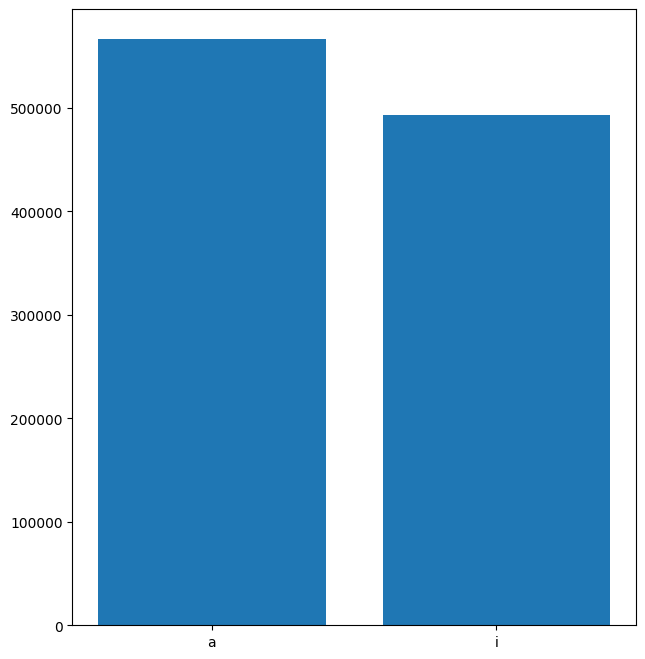

In [ ]:
# Graph for Stopwords
top10_stopwords = sorted(stopwords_dict.items(), key=lambda x:x[1], reverse=True)[:10]
x0,y0 = zip(*top10_stopwords)

plt.figure(1, figsize=(16,8))
plt.subplot(1,2,1)
plt.bar(x0,y0)

<BarContainer object of 10 artists>

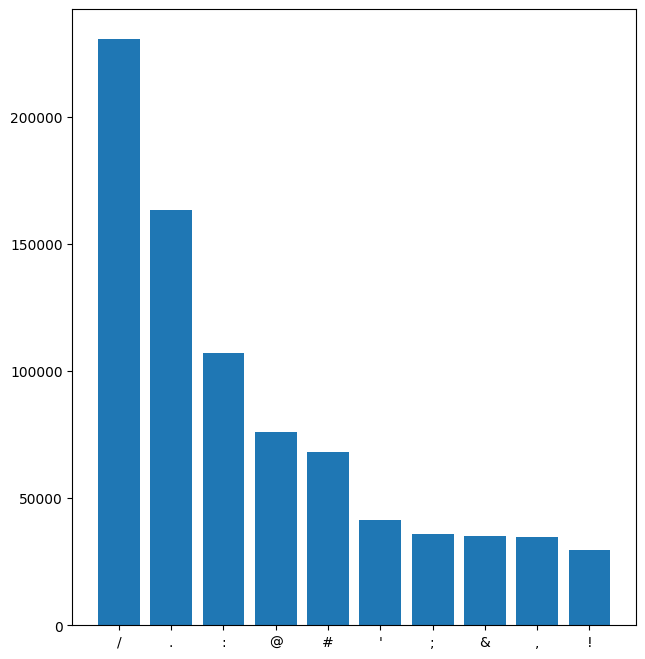

In [ ]:
# Graph for punct
top10_punct = sorted(punc.items(), key=lambda x:x[1], reverse=True)[:10]
x0,y0 = zip(*top10_punct)

plt.figure(1, figsize=(16,8))
plt.subplot(1,2,1)
plt.bar(x0,y0)

###Percentage of Different Labels in the Dataset:-
The percentage of different labels in the dataset tells us about the distribution of classes in the dataset. It provides insight into the imbalance or balance of the dataset. This is particularly important in classification tasks where the classes are not equally represented.

Therefore, understanding the percentage of different labels in the dataset can help us evaluate the quality of the dataset and make informed decisions about how to balance the dataset if necessary.

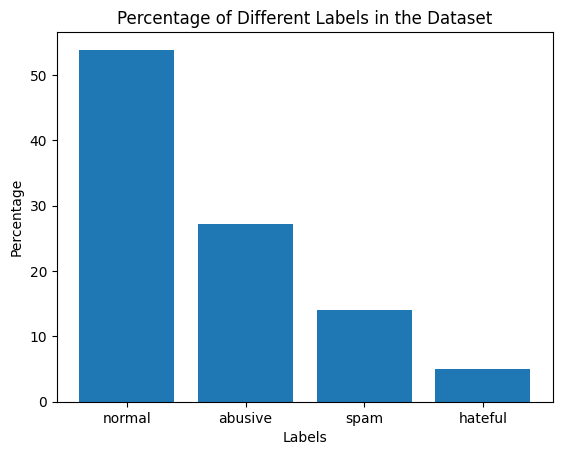

In [ ]:
# Calculate the percentage of each label
label_counts = data_hatespeech['labels'].value_counts(normalize=True) * 100

# Create a bar chart
plt.bar(label_counts.index, label_counts.values)

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Percentage')
plt.title('Percentage of Different Labels in the Dataset')

# Display the chart
plt.show()

The plot tells us that about 70% of tweets are abusive, 15% of tweets are hateful, 10% of tweets are normal and 5% are spam.


Counting the number of different labels in a dataset can provide important insights into the distribution of the data. It tells us the number and proportion of each label in the dataset, which can be useful in determining the class balance or class imbalance of the dataset.

In [ ]:
# Count the number of different labels
label_counts = data_hatespeech['labels'].value_counts()

# Display the result
print(label_counts)

normal     53851
abusive    27150
spam       14030
hateful     4965
Name: labels, dtype: int64


There are 740 abusive, 168 hateful, 114 normal and 18 spam

###Network Graph of Tweet Relationships:-
A network graph of tweet relationships shows the connections between different Twitter users based on their interactions with each other's tweets.

Overall, network graphs of tweet relationships can provide a visual representation of the complex interactions and connections between Twitter users, allowing for deeper analysis and insights into the data.

In [ ]:
import networkx as nx

So as there are 4 labels in our dataset we want to show there relationship through network graph in there respective category and then after mixing the category i.e. in combined group.

First lets see the network graph of Hateful category.

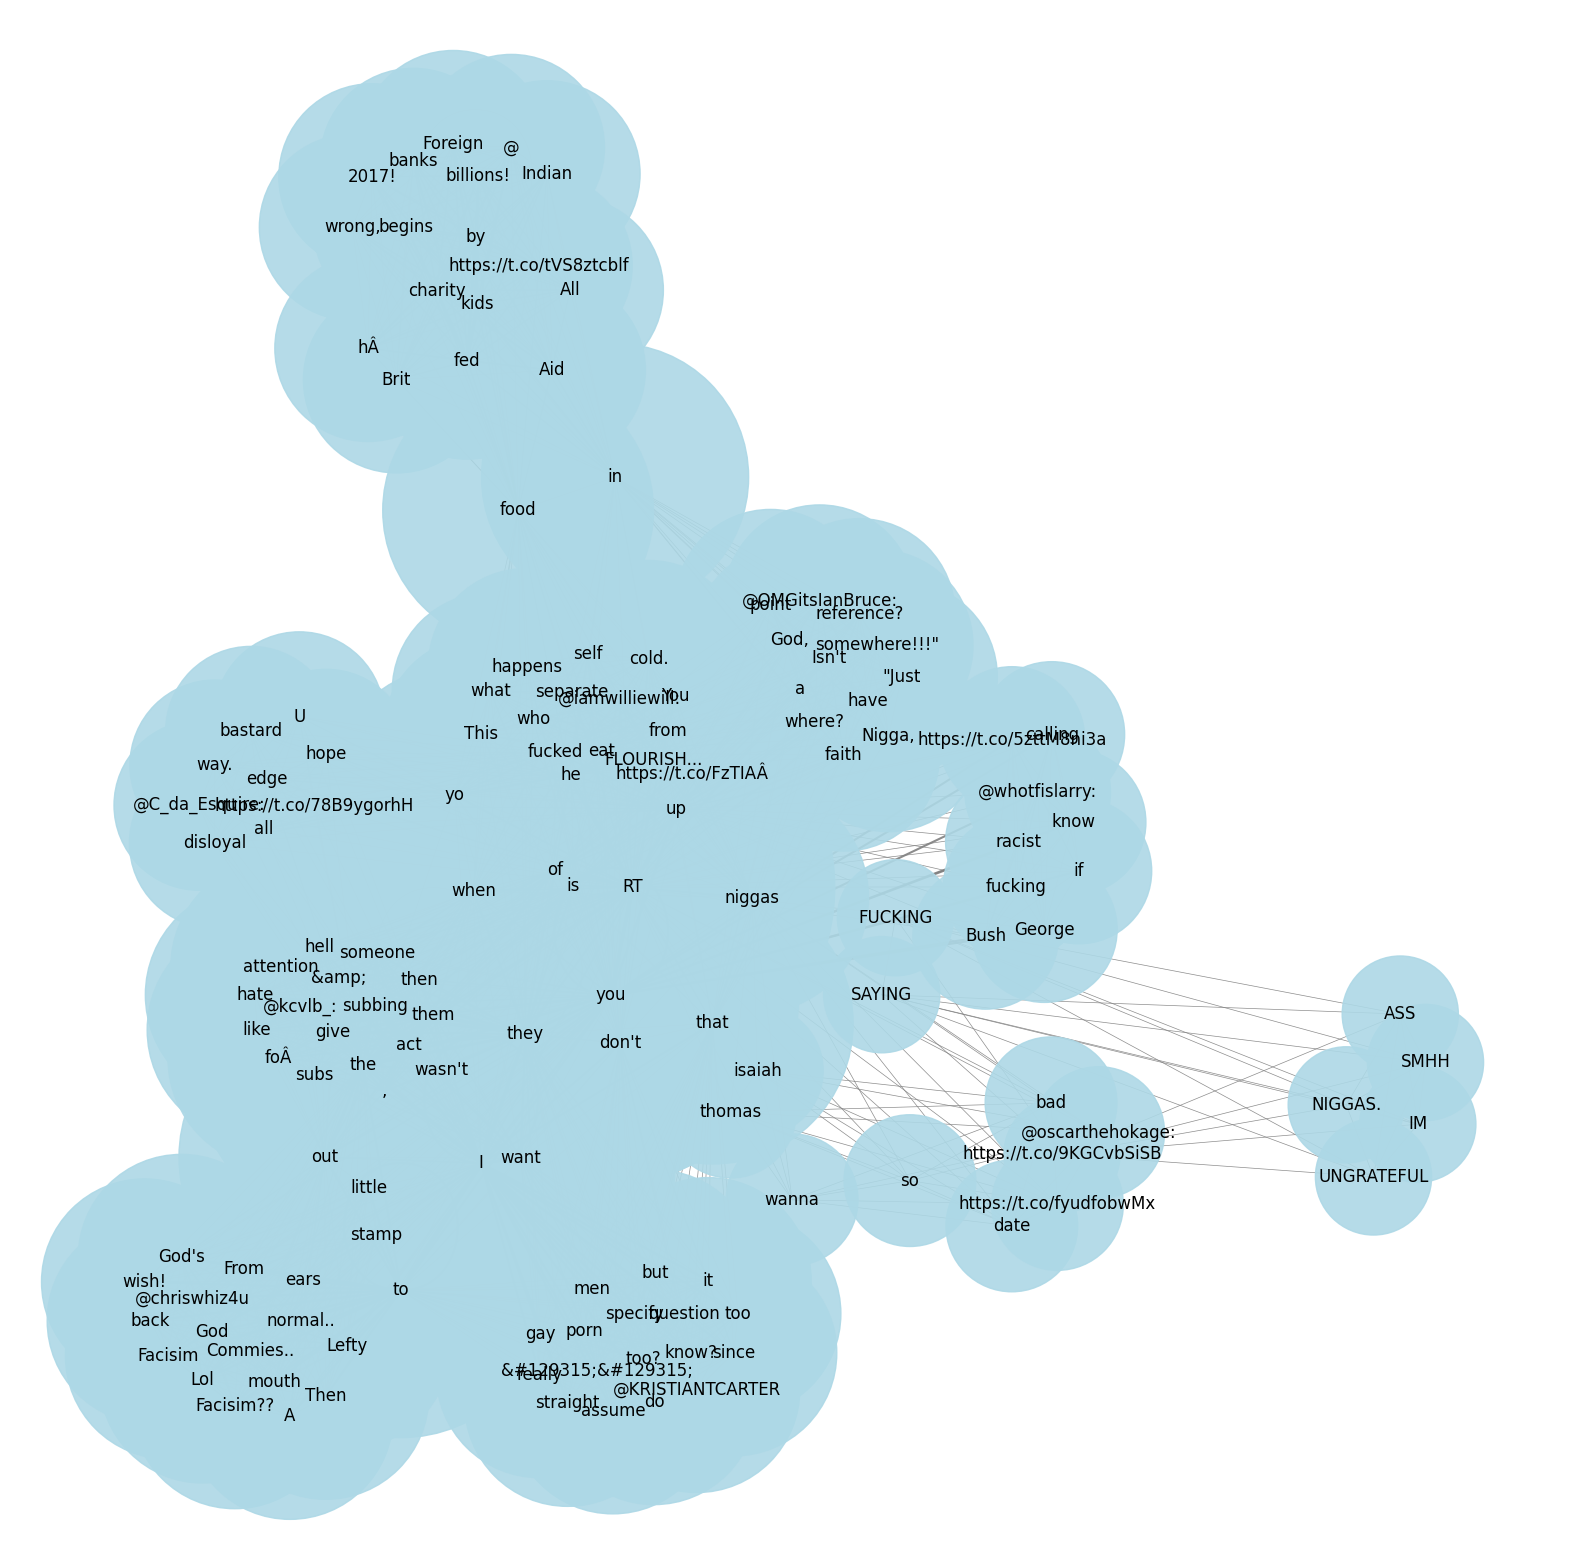

In [ ]:
# Read the data and filter out random 10 rows of the hateful category
df_hateful = data_hatespeech[data_hatespeech['labels']=='hateful'].sample(n=10)

# Create a graph from the data
G = nx.Graph()
for index, row in df_hateful.iterrows():
    tokens = row['tweets'].split()
    for i in range(len(tokens)-1):
        for j in range(i+1, len(tokens)):
            token1 = tokens[i]
            token2 = tokens[j]
            if G.has_edge(token1, token2):
                G[token1][token2]['weight'] += 1
            else:
                G.add_edge(token1, token2, weight=1)

# Define the layout of the nodes
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Define the size of the nodes based on the node degree
node_size = [1000*G.degree(n) for n in G.nodes()]

# Define the width of the edges based on the edge weight
edge_width = [0.5*G[u][v]['weight'] for u,v in G.edges()]

# Draw the graph
plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='lightblue', alpha=0.9)
nx.draw_networkx_edges(G, pos, width=edge_width, edge_color='gray', alpha=0.9)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
plt.axis('off')
plt.show()

Abusive

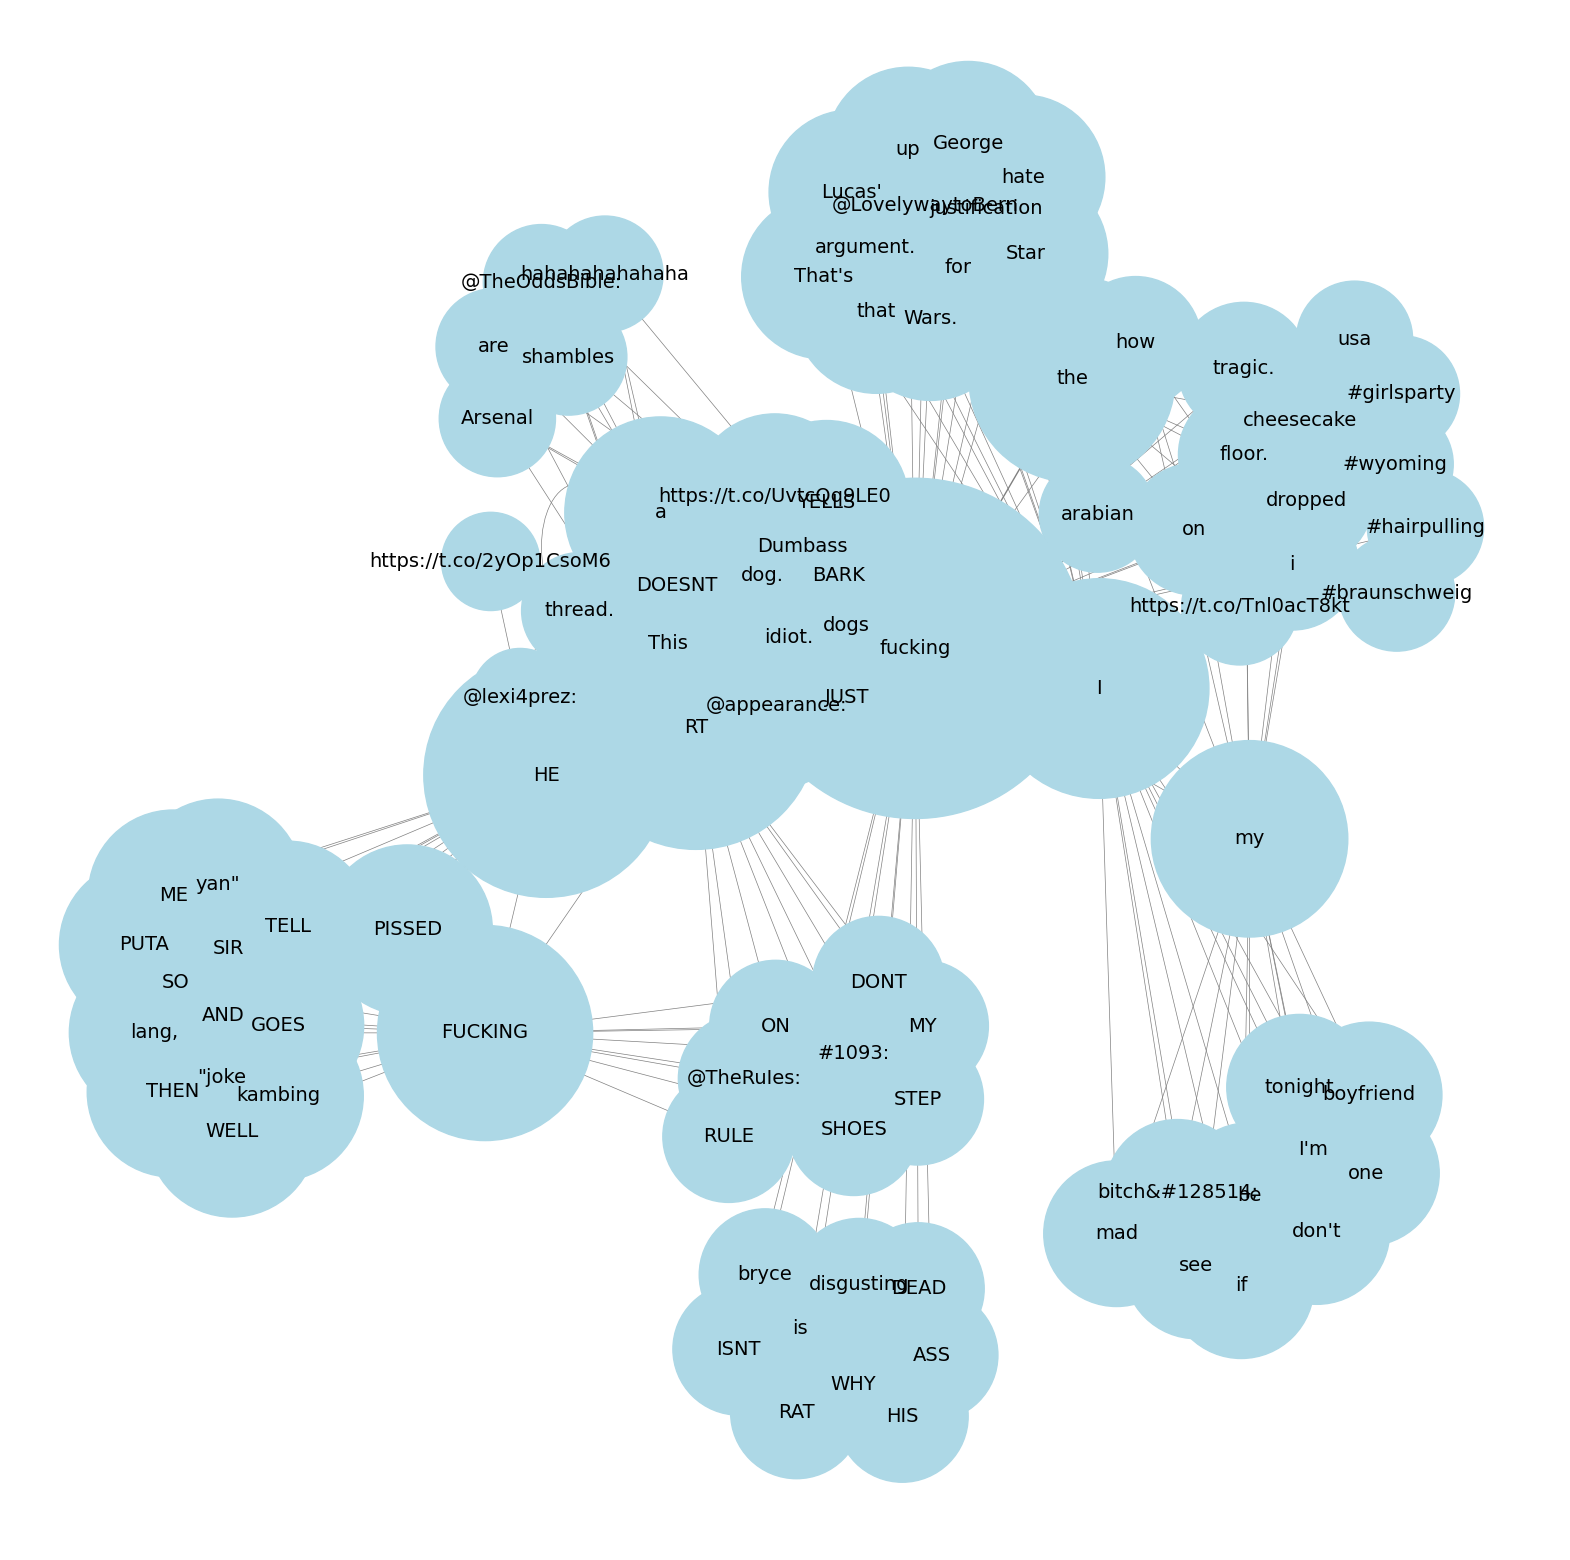

In [ ]:
# Read the data and filter out random 10 rows of the hateful category
df_hateful = data_hatespeech[data_hatespeech['labels']=='abusive'].sample(n=10)

# Create a graph from the data
G = nx.Graph()
for index, row in df_hateful.iterrows():
    tokens = row['tweets'].split()
    for i in range(len(tokens)-1):
        for j in range(i+1, len(tokens)):
            token1 = tokens[i]
            token2 = tokens[j]
            if G.has_edge(token1, token2):
                G[token1][token2]['weight'] += 1
            else:
                G.add_edge(token1, token2, weight=1)

# Define the layout of the nodes
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Define the size of the nodes based on the node degree
node_size = [1000*G.degree(n) for n in G.nodes()]

# Define the width of the edges based on the edge weight
edge_width = [0.5*G[u][v]['weight'] for u,v in G.edges()]

# Draw the graph
plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='lightblue', alpha=1)
nx.draw_networkx_edges(G, pos, width=edge_width, edge_color='gray', alpha=1)
nx.draw_networkx_labels(G, pos, font_size=14, font_family='sans-serif')
plt.axis('off')
plt.show()

Spam

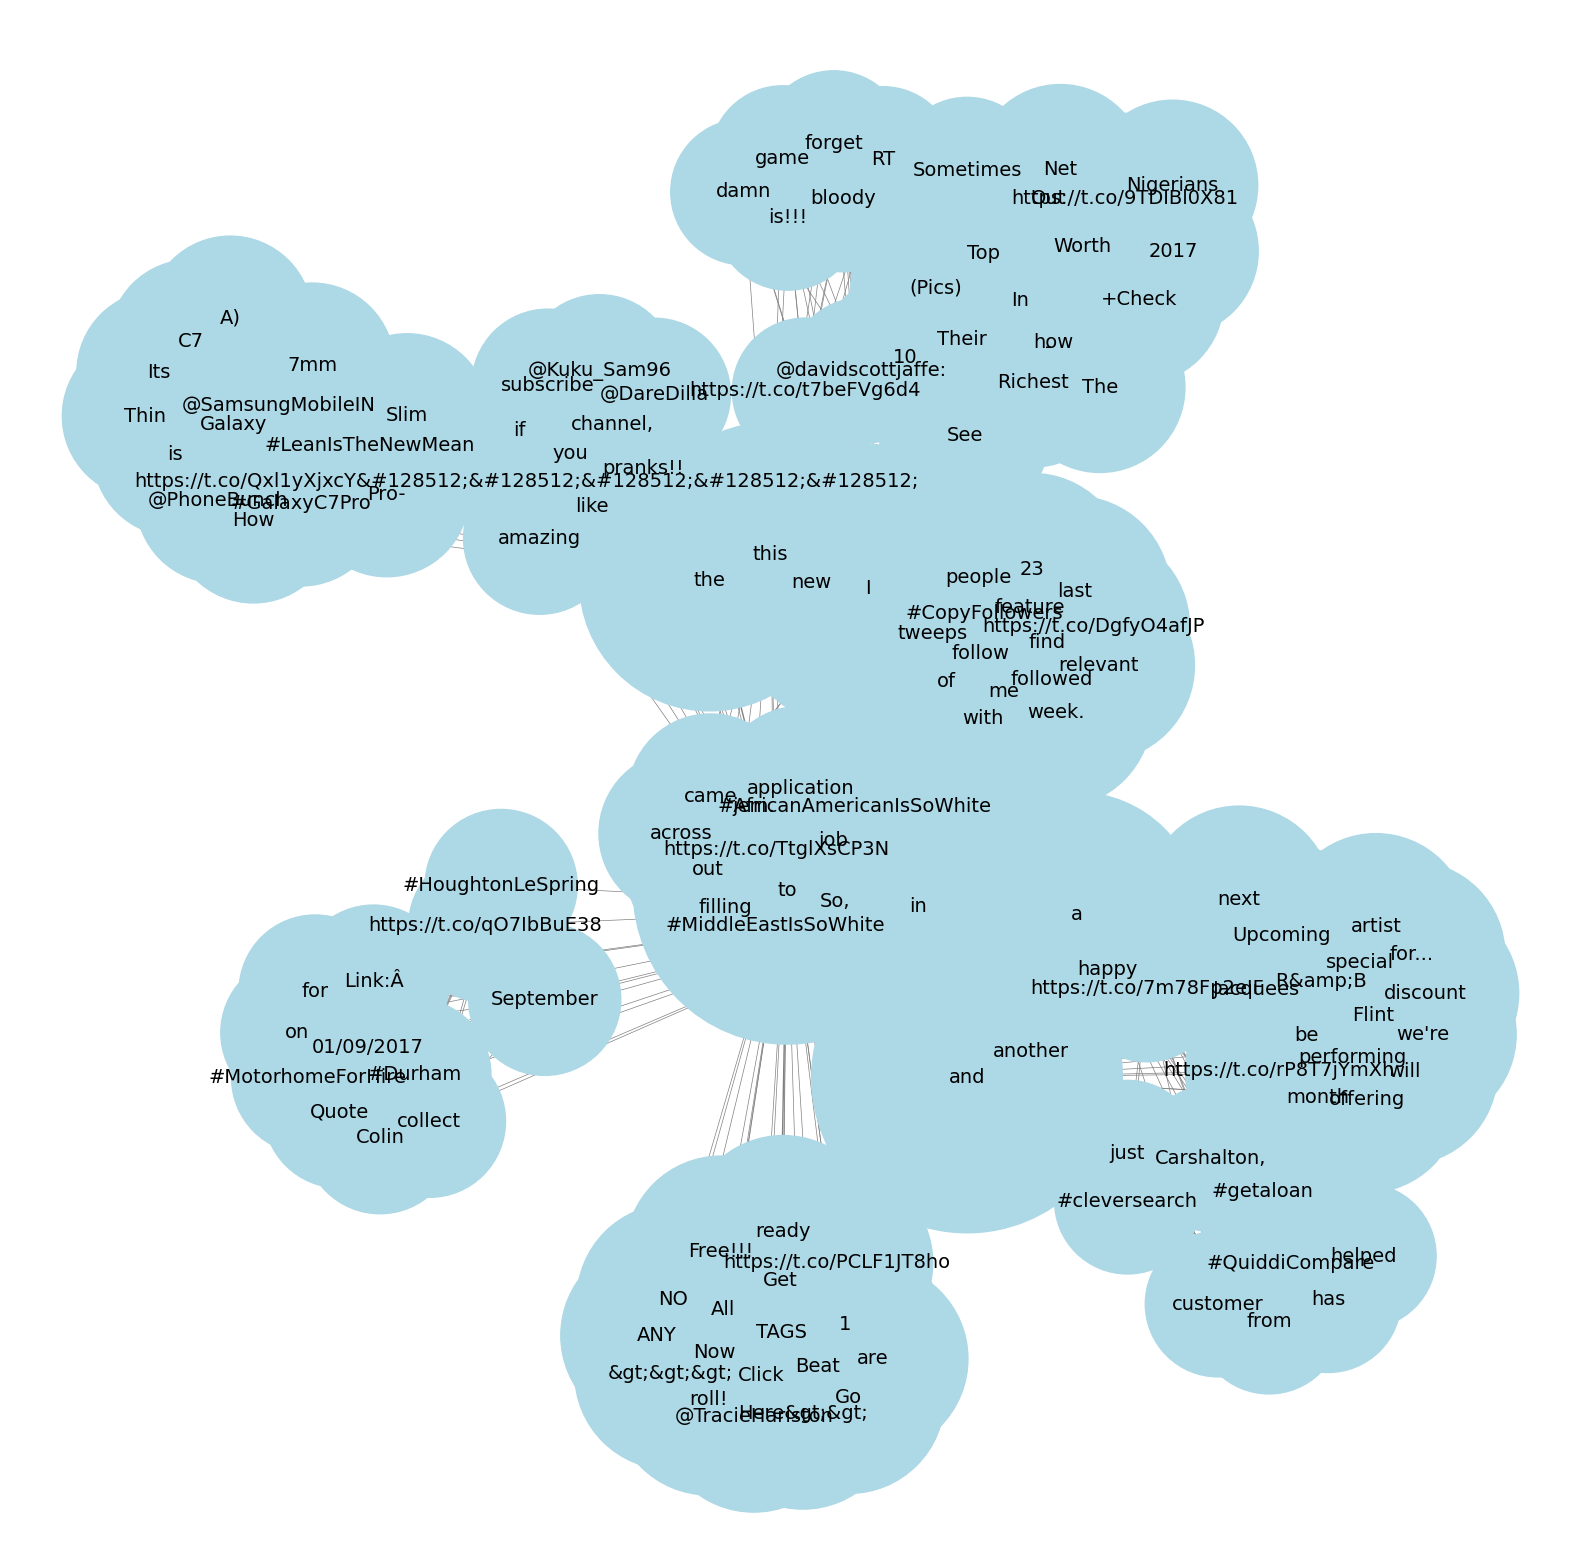

In [ ]:
# Read the data and filter out random 10 rows of the hateful category
df_hateful = data_hatespeech[data_hatespeech['labels']=='spam'].sample(n=10)

# Create a graph from the data
G = nx.Graph()
for index, row in df_hateful.iterrows():
    tokens = row['tweets'].split()
    for i in range(len(tokens)-1):
        for j in range(i+1, len(tokens)):
            token1 = tokens[i]
            token2 = tokens[j]
            if G.has_edge(token1, token2):
                G[token1][token2]['weight'] += 1
            else:
                G.add_edge(token1, token2, weight=1)

# Define the layout of the nodes
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Define the size of the nodes based on the node degree
node_size = [1000*G.degree(n) for n in G.nodes()]

# Define the width of the edges based on the edge weight
edge_width = [0.5*G[u][v]['weight'] for u,v in G.edges()]

# Draw the graph
plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='lightblue', alpha=1)
nx.draw_networkx_edges(G, pos, width=edge_width, edge_color='gray', alpha=1)
nx.draw_networkx_labels(G, pos, font_size=14, font_family='sans-serif')
plt.axis('off')
plt.show()

Normal

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 147 (\x93) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 148 (\x94) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 146 (\x92) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


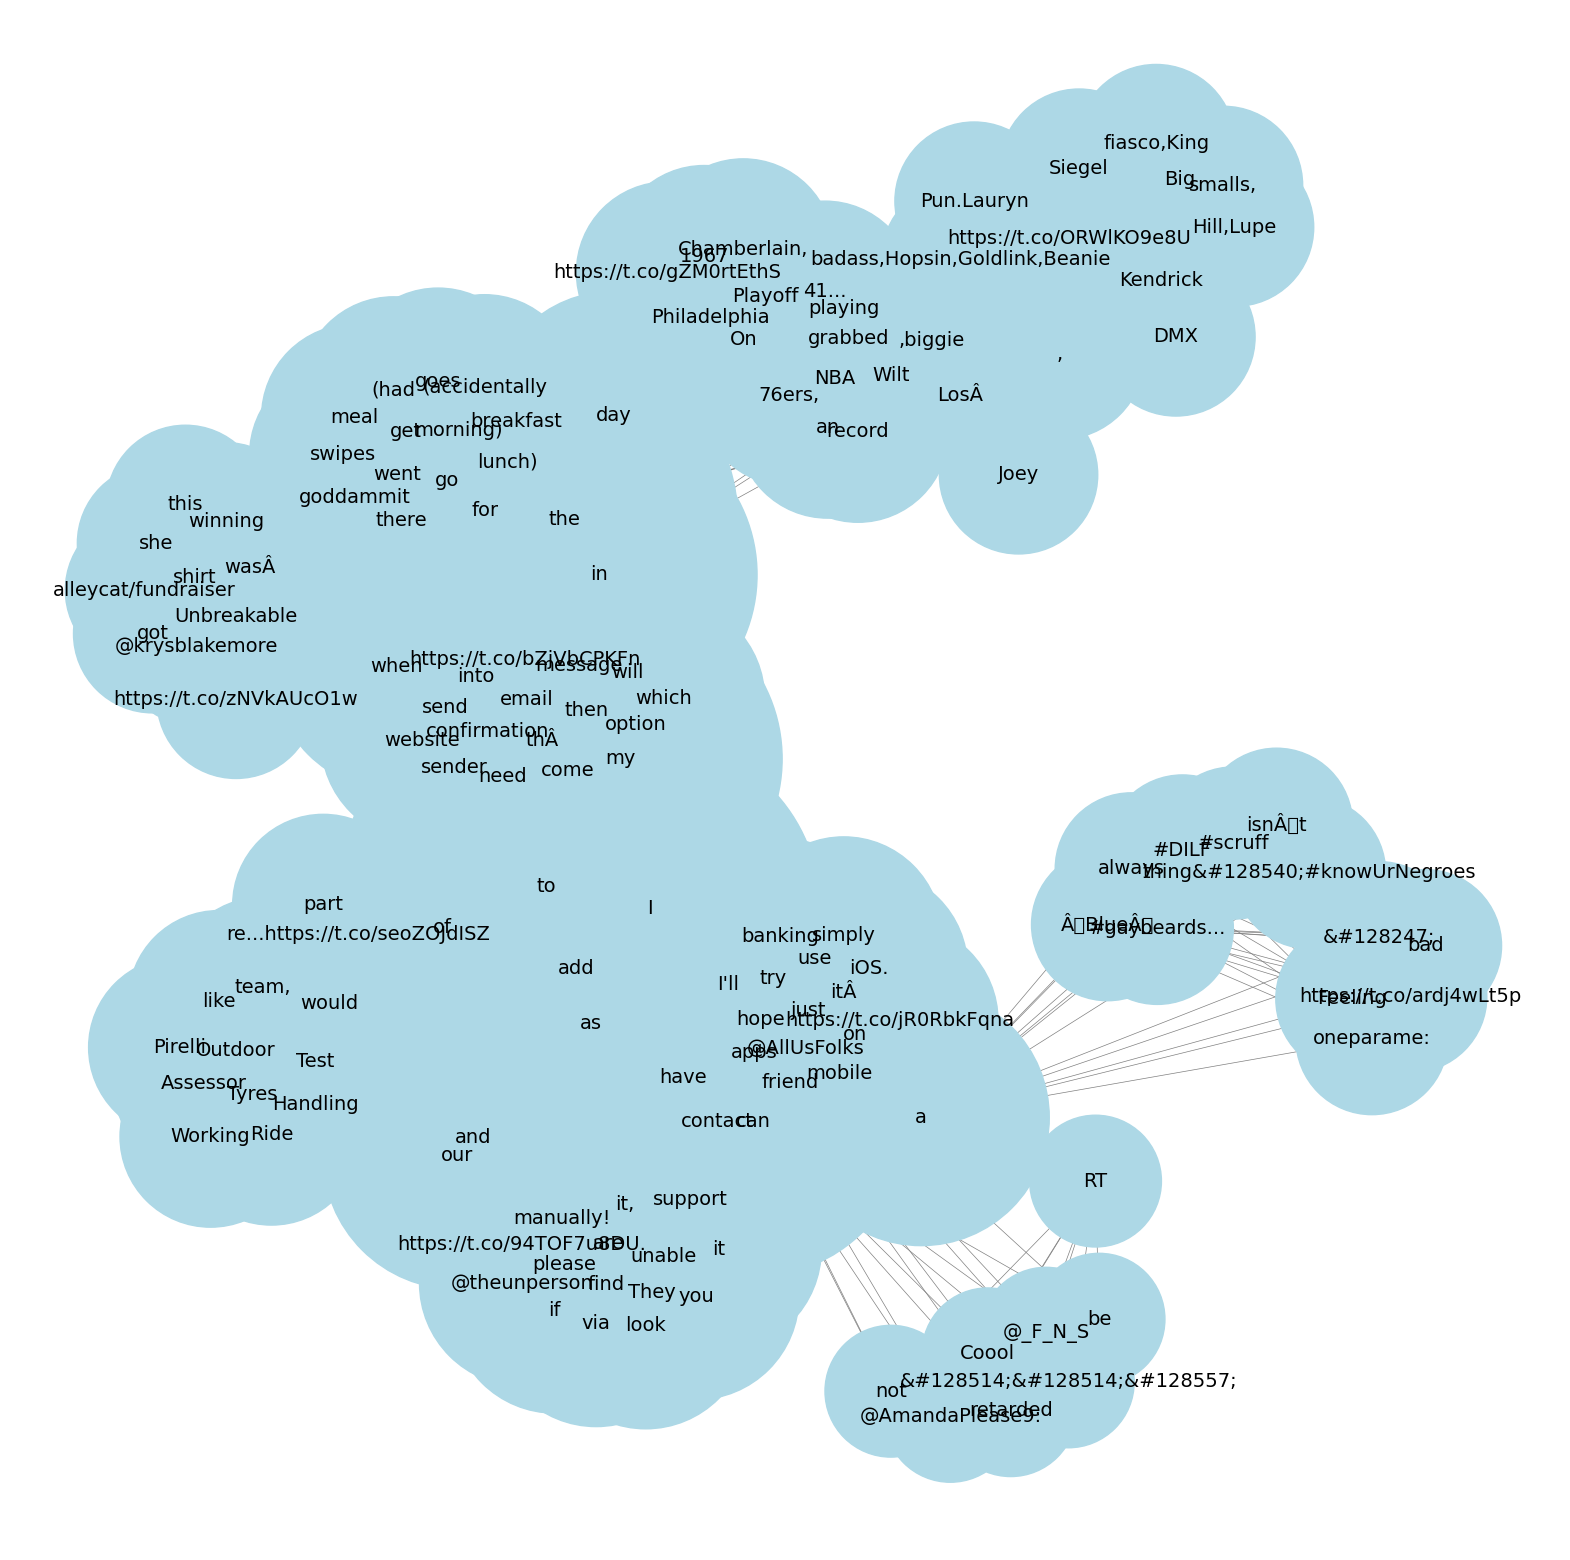

In [ ]:
df_hateful = data_hatespeech[data_hatespeech['labels']=='normal'].sample(n=10)


# Create a graph from the data
G = nx.Graph()
for index, row in df_hateful.iterrows():
    tokens = row['tweets'].split()
    for i in range(len(tokens)-1):
        for j in range(i+1, len(tokens)):
            token1 = tokens[i]
            token2 = tokens[j]
            if G.has_edge(token1, token2):
                G[token1][token2]['weight'] += 1
            else:
                G.add_edge(token1, token2, weight=1)

# Define the layout of the nodes
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Define the size of the nodes based on the node degree
node_size = [1000*G.degree(n) for n in G.nodes()]

# Define the width of the edges based on the edge weight
edge_width = [0.5*G[u][v]['weight'] for u,v in G.edges()]

# Draw the graph
plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='lightblue', alpha=1)
nx.draw_networkx_edges(G, pos, width=edge_width, edge_color='gray', alpha=1)
nx.draw_networkx_labels(G, pos, font_size=14, font_family='sans-serif')
plt.axis('off')
plt.show()

Concatenated Data of all the labels

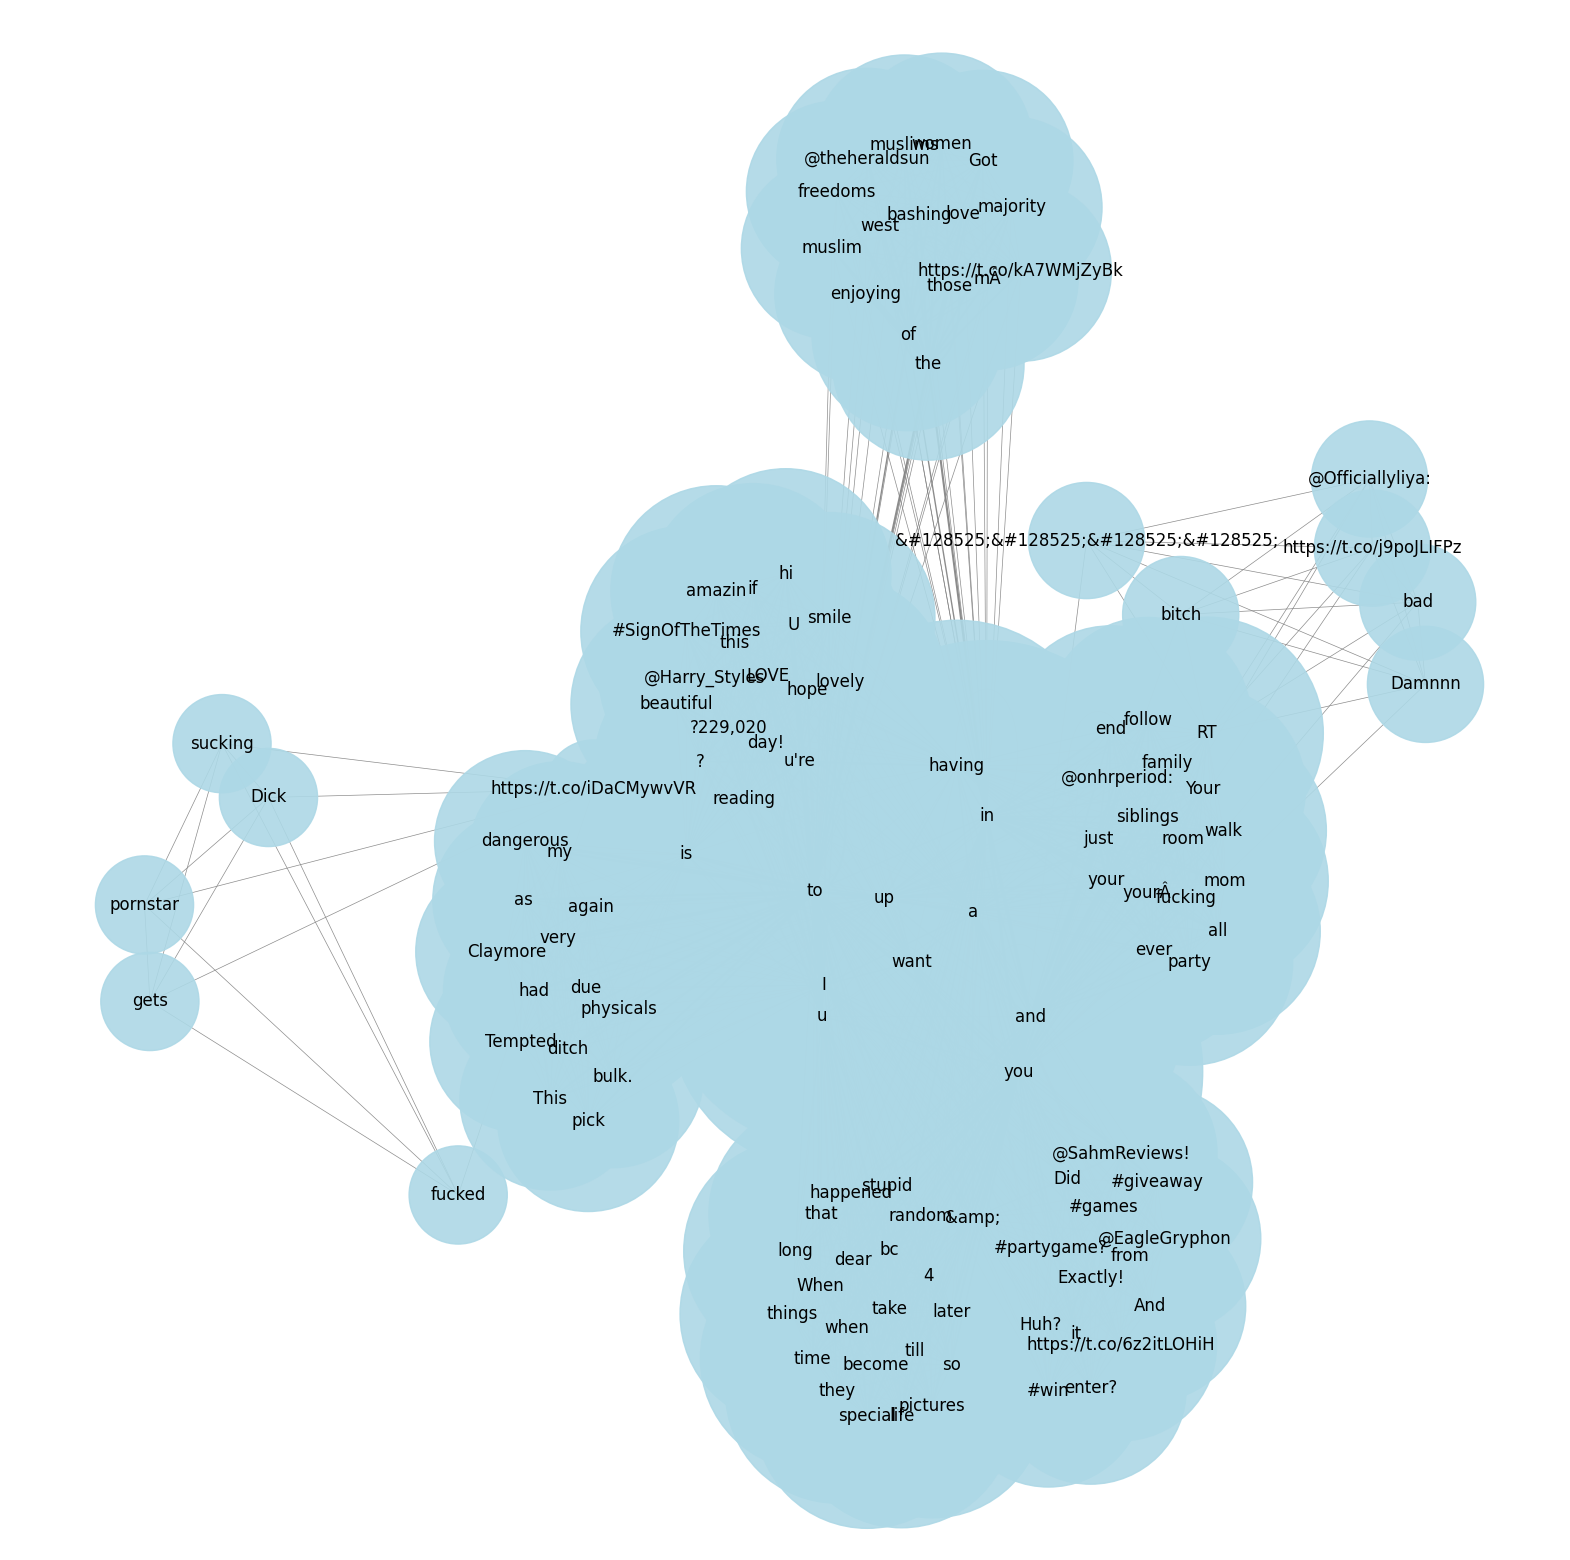

In [ ]:
df_hateful = data_hatespeech[data_hatespeech['labels']=='hateful'].sample(n=2)
df_abusive = data_hatespeech[data_hatespeech['labels']=='abusive'].sample(n=2)
df_spam = data_hatespeech[data_hatespeech['labels']=='spam'].sample(n=2)
df_normal = data_hatespeech[data_hatespeech['labels']=='normal'].sample(n=2)

# Concatenate the data into one dataframe
df_sample = pd.concat([df_hateful, df_abusive, df_spam, df_normal])

# Create a graph from the data
G = nx.Graph()
for index, row in df_sample.iterrows():
    tokens = row['tweets'].split()
    for i in range(len(tokens)-1):
        for j in range(i+1, len(tokens)):
            token1 = tokens[i]
            token2 = tokens[j]
            if G.has_edge(token1, token2):
                G[token1][token2]['weight'] += 1
            else:
                G.add_edge(token1, token2, weight=1)

# Define the layout of the nodes
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Define the size of the nodes based on the node degree
node_size = [1000*G.degree(n) for n in G.nodes()]

# Define the width of the edges based on the edge weight
edge_width = [0.5*G[u][v]['weight'] for u,v in G.edges()]

# Draw the graph
plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='lightblue', alpha=0.9)
nx.draw_networkx_edges(G, pos, width=edge_width, edge_color='gray', alpha=0.9)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
plt.axis('off')
plt.show()

### Training the model

Now we will prepare the data for training the model. Here we have **2 Methods**. The **Method 1** failed as the model is overfitting on majority class. But we used our own custom tokenization, Normalization and TD-IDF functions to create the final TD-IDF vector for model to train. In this after making various changes in combination of model kernals and above mentioned functions, the heightest model accurcay we got is of 70% and lowest being 52%, but zero precision & recall on all the classes except the class which had majority in dataset.

In **Method 2** we used TfidfVectorizer() from sklearn and used following paramters (stop_words='english', lowercase=True). This led to a accuracy of 80% with good precision & recall on all the classes.

### Method 1

##Splitting into Test and Train data

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Split the dataset into training and testing sets. Using only 10k of 100k.
data_hatespeech_10k = data_hatespeech[:10000]
X_train, X_test, y_train, y_test = train_test_split(data_hatespeech_10k['tweets'], data_hatespeech_10k['labels'], test_size=0.2, random_state=42)

In [ ]:
y_train.value_counts()

normal     4331
abusive    2146
spam       1127
hateful     396
Name: labels, dtype: int64

## Tokenization

Tokenization (splitting text into individual words), removing stop words, lemmatizing words, and removing emojis, symbols characters.

In [ ]:
"""
Reference: Kabilesh, KabileshKabilesh 98466 gold badges2020 silver badges4646 bronze badges, TimTim 2, NickNick 3, sougata sahasougata saha4766 bronze badges, &amp; toshi456toshi45620311 silver badge77 bronze badges.(1965, September 1). Unable to remove some emojis from tweets in Python. Stack Overflow. Retrieved March 24, 2023, from https://stackoverflow.com/questions/53322870/unable-to-remove-some-emojis-from-tweets-in-python 
Function for emoji removal
"""
# Function to remove the emojis
def remove_emoji(token):
  regrex_pattern = re.compile(pattern = "["
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
          u"\U00002500-\U00002BEF"  # chinese char
          u"\U00002702-\U000027B0"
          u"\U00002702-\U000027B0"
          u"\U000024C2-\U0001F251"
          u"\U0001f926-\U0001f937"
          u"\U00010000-\U0010ffff"
          u"\u2640-\u2642"
          u"\u2600-\u2B55"
          u"\u200d"
          u"\u23cf"
          u"\u23e9"
          u"\u231a"
          u"\ufe0f"  # dingbats
          u"\u3030"
                            "]+", flags = re.UNICODE)
  return regrex_pattern.sub(r'', token)

In [ ]:
# Tokenization (splitting text into individual words), removing stop words, lemmatizing words, and removing emojis, symbols characters.
def tokenize(docs, lemmatized=True, remove_stopword=True, remove_punct = True):
    
    tokenized_docs = []

    for doc in docs:
      doc = nlp(doc)
      doc_tokenized = []
      
      # Lemmatized
      for token in doc:
        if lemmatized:
          doc_tokenized.append(token.lemma_)
        else:
          doc_tokenized.append(token.text)

      # Removing Noises like @, links, # and emojis from the tweets
      temp_tokens = []
      for token in doc_tokenized:
        token = token.strip() #Removing empty tokens
        if token.startswith('@') and len(token) > 1:
          token = '@user'
        elif token.startswith('http'):
          token = 'http'
        elif token.startswith('#'):
          token = token.replace("#", "")
        else:
            token = remove_emoji(token)
        temp_tokens.append(token)
      doc_tokenized = temp_tokens
    
      # Remove Stopwords from the tokens
      if remove_stopword:
        temp_tokens = []
        stopwords = spacy.lang.en.stop_words.STOP_WORDS
        for token in doc_tokenized:
          if token.lower() not in stopwords:
            temp_tokens.append(token.lower())
        doc_tokenized = temp_tokens

        #doc_tokenized = [token for token in doc_tokenized if str(token).lower() not in stopwords]

      # Removed Punc
      if remove_punct:
        doc_tokenized = " ".join([token for token in doc_tokenized])
        doc_tokenized = nlp(doc_tokenized)
        doc_tokenized = [token for token in doc_tokenized if not token.is_punct]

      tokenized_docs.append(doc_tokenized)

    return tokenized_docs

In [ ]:
tokenized_tweets_train = tokenize(X_train, lemmatized=True, remove_stopword=True, remove_punct = True)
print(len(tokenized_tweets_train))

8000


In [ ]:
tokenized_tweets_test = tokenize(X_test, lemmatized=True, remove_stopword=True, remove_punct = True)
print(len(tokenized_tweets_test))

2000


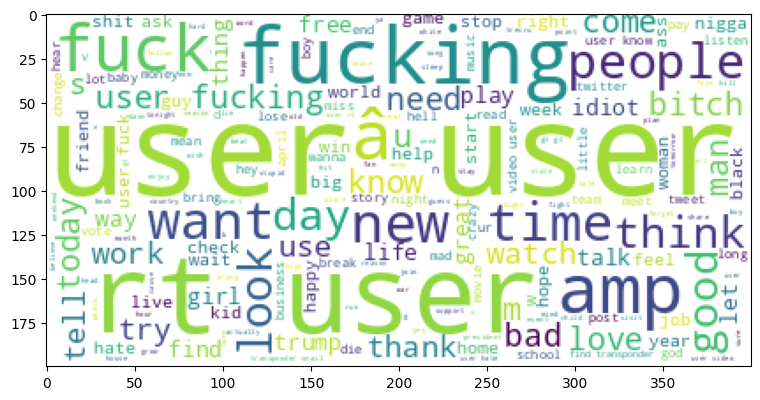

In [ ]:
# Plotting graph showing most used words in the train dataset
from wordcloud import WordCloud

all_words = []
for tokenized_tweet in tokenized_tweets_train:
  for word in tokenized_tweet:
    all_words.append(word.text)
    
word_cloud = WordCloud(background_color="white", max_font_size=80).generate(" ".join(all_words))
plt.figure(1, figsize=(20, 18))
plt.subplot(1,2,1)
plt.imshow(word_cloud)

## Normalization

## First we will do it for train data
So here our goal is to normalize the data. This is to rescale the features of a dataset so that they all have a similar range and magnitude. This is done to ensure that no feature dominates or biases the analysis, as some features may have a larger scale than others.

In [ ]:
# using dictionary comprehension for iteration
tokenized_tweets_dict = {idx : tokenized_tweets_train[idx] for idx in range(len(tokenized_tweets_train))}

# Find the count of each unique token and save the count as a dictionary, named word_dict, i.e., {world: 1, a: 1, ...}
from collections import Counter
for i, para in enumerate(tokenized_tweets_dict.values()):
  word_dict = dict(Counter(para))
  tokenized_tweets_dict[i] = word_dict

print(tokenized_tweets_dict)

{0: {rt: 1, @user: 1, yo: 1, fucking: 1, hat: 1,  : 1, 128514: 1, http: 1}, 1: {rt: 1, @user: 1, oh: 1, lord: 1, idiot: 1, drexel: 1, university: 1, professor: 1,  : 1, tuckercarlsontonight: 1, http: 1}, 2: {time: 1, fucking: 1, let: 1, statement: 1, tonight: 1,  : 1, mufc: 1}, 3: {commentary: 1, emily: 1, allen: 1, rev: 1, kent: 1, ingram: 1, write: 1, 2016: 1, western: 1, jurisdictionâs: 1, election: 1, http: 1}, 4: {like: 1, @user: 1, video: 1, @user: 1, http: 1, lest: 1, enjoy: 1, duty: 1, ww2: 1, come: 1}, 5: {stop: 1, shady: 1, ass: 1, motel: 1, middle: 1, night: 1, amp: 1, owner: 1, tell: 1, taxidermy: 1, fuck: 1, outta: 1,  : 1, batesmotel: 1}, 6: {rt: 1, @user: 1, lisa: 1, hair: 1, fuck: 1, yg: 1, stylist: 1, hate: 1, http: 1}, 7: {happy: 1, free: 1, flit: 1, activit: 1, gemini: 1, http: 1}, 8: {want: 1, fucking: 1, stand: 1, roman: 1}, 9: {rt: 1, @user: 1, let: 1, u: 1, know: 1, protest: 1, law: 1, shoot: 1, yo: 1, ass: 1, stupid: 1, phone: 1, case: 1,  : 1, 128514;&#128514:

Here we are finding the unique word for the dataset.

**Note: Unique words will remain same for all model training and at time of pipelining. This is beacause we want to compare data to same set of unique words and also we don't want to change the matrix (shape) for model training.**

In [ ]:
# Pools the keys from all the word dictionaries to get a list of unique words, denoted as unique_words
unique_words = set()
for li in tokenized_tweets_dict.values():
  for word in li.keys():
    unique_words.add(word)
unique_words = list(unique_words)
print(unique_words)
print(len(unique_words))
unique_train = unique_words

[cha,  , http, amp, guarantee, let, owens, episode, rt, listen, melaninfashion, http, virginia, 128525;&#128525;&#128525;&#127801;&#127801;&#127801;&#128079;&#128079;&#128079, faggot, rt, @user, girl, need, tigers,  , @user, girl, dread, @user,  , http, hell, feat, agent, completely, vibe, interesting, advice, 127475;&#127487;prince&#128035;leon&#128081;&#128293,  , cute, group, need, learn, friend, stfu, heâs, dirt, work, ugly, game, rt, 20, earn, china, need, fucking, 3*(4, @user, @user, rt, et, @user, york, december, calm, fish, lamb,  , wrist, theseâ, @user, link, like, like,  , hello, rt, vote, thing, crazy, ken, tranny, rt,  , bad, @user, smythe, @user, |, hate, fire, free, itgetsworseshow, thebenefitscap, post, amp, automatically, ipad, ios, http, blood, flash, brexit, find, alia, turn, fucking, tristan, lovely, scale, update, n, didi, feeling, cheap, health, sooooo, spring, ps, thank, mm, rate, young, 128514;&#128514, man, whywefundraise, damn,  ,  , @user, retard, save, exclu

In [ ]:
# Creates a numpy array, say dtm with a shape (# of tokenized_tweets_dict x # of unique words), and set the initial values to 0.
dtm = np.zeros((len(tokenized_tweets_dict.keys()), len(unique_words)))
dtm.shape

(8000, 86374)

In [ ]:
# Create a sparse matrix with the same shape as dtm
sparse_dtm = sp.lil_matrix(dtm.shape)

# Fill in the matrix using the same logic as before
for i, j in enumerate(sparse_dtm.rows):
    for k in range(len(j)):
        if unique_words[k] in tokenized_tweets_dict[i]:
            sparse_dtm[i, k] = tokenized_tweets_dict[i][unique_words[k]]

In [ ]:
# Convert dtm to a sparse matrix
sparse_dtm = sp.csr_matrix(dtm)

# Calculates the paragraph frequency for each word
k = sp.csr_matrix(sparse_dtm > 0, dtype=int)
df = np.array(k.sum(axis=0))[0]

# Normalizes the word count per paragraph, adding a minute constant to the denominator to avoid dividing by zero.
eps = 1e-10
normalized_dtm = sparse_dtm.multiply(1 / (sparse_dtm.sum(axis=1) + eps))

normalized_dtm

<2000x86374 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in COOrdinate format>

## Tf-Idf

Now, we Initiallized the vectorizer with the desired parameters that are, with smoothed_idf,a smoothing factor is added to the formula. Smoothing the IDF helped us to reduce the impact of rare words and to make the IDF score more stable across the corpus, and "use_idf" which measures how important a term is within a corpus, by taking into account the frequency of the term in all documents. Terms that are common in all documents are given a low IDF weight, whereas terms that are rare in the corpus are given a high IDF weight.

The use of IDF weight in conjunction with the term frequency (TF) weight of each term in the document is what makes the TF-IDF (Term Frequency-Inverse Document Frequency) approach a powerful technique in information retrieval and text mining. It allows to effectively represent the importance of terms in a document and to distinguish the relevant terms from the irrelevant ones. Then, we fit and transformed the vectorizer on the tokenized documents and get the final weights of the terms.


In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

# Instantiate the TfidfTransformer with smooth_idf=True to avoid dividing by zero
tfidf_transformer = TfidfTransformer(smooth_idf=True)

# Apply the TF-IDF transformation to the normalized DTM
tfidf_matrix = tfidf_transformer.fit_transform(normalized_dtm)

# Convert the sparse matrix to a dense numpy array for easier manipulation
dense_tfidf_matrix = tfidf_matrix.toarray()

# Print the shape of the dense TF-IDF matrix
print(dense_tfidf_matrix.shape)

(2000, 86374)


So here we are converting target values in y_train into numeric values using Label Encoder

In [ ]:
y_train

9254    abusive
1561    hateful
1670    abusive
6087     normal
6669       spam
         ...   
5734     normal
5191     normal
5390    hateful
860        spam
7270     normal
Name: labels, Length: 8000, dtype: object

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Fit the LabelEncoder object to the categorical labels in y_train
le.fit(y_train)

# Transform the categorical labels in y_train to numerical values
y_train_encoded = le.transform(y_train)
y_train_encoded.shape

(8000,)

## Training the hatespeech classification model using SVM

In [ ]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(dense_tfidf_matrix, y_train_encoded)

SVC()

# Then normalization and Td/idf for Test data

In [ ]:
# using dictionary comprehension for iteration
tokenized_tweets_dict = {idx : tokenized_tweets_test[idx] for idx in range(len(tokenized_tweets_test))}

# Find the count of each unique token and save the count as a dictionary, named word_dict, i.e., {world: 1, a: 1, ...}
from collections import Counter
for i, para in enumerate(tokenized_tweets_dict.values()):
  word_dict = dict(Counter(para))
  tokenized_tweets_dict[i] = word_dict

print(tokenized_tweets_dict)

{0: {hater: 1, italian: 1, english: 1, story: 1, h.s: 1,  : 1, wattys2017: 1, su: 1,  : 1, wattpad: 1, http: 1, http: 1}, 1: {heartbreake: 1, photo: 1, father: 1, cradle: 1, 9: 1, month: 1, old: 1, twin: 1, kill: 1, http: 1, byâ: 1,  : 1, http: 1}, 2: {riding: 1, dick: 1, grind: 1, fucking: 1, suana: 1, http: 1}, 3: {top*185: 1, g: 1, carve: 1, natural: 1, smoky: 1, quartz: 1, crystal: 1, alien: 1, skull: 1, healing: 1, http: 1, http: 1}, 4: { : 1, lesbian: 1, daughter: 1, sex: 1, girl: 1, fuck: 1, guy: 1, http: 1}, 5: {rt: 1, @user: 1, watch: 1, ur: 1, fucking: 1, mouf: 1, boy: 1, http: 1}, 6: {rt: 1, @user: 1, blast: 1, music: 1, feel: 1, fucking: 1, thing: 1}, 7: {fuck: 1, olivia: 1,  : 1, scandal: 1, http: 1}, 8: {hateful: 1, arrogant: 1, bastard: 1, hell: 1, survive: 1, crazy: 1, horse: 1, trumputin: 1, amp: 1, mis: 1, administration: 1, thâ: 1,  : 1, http: 1}, 9: {binge: 1, watch: 1, season: 1, twice: 1, start: 1, ask: 1, season: 1, come: 1, http: 1}, 10: {ai: 1, fuck: 1, tranny:

## Unique word will remain same

This is because the vocab (unique words) for the model to predict will be same.

In [ ]:
# Creates a numpy array, say dtm with a shape (# of tokenized_tweets_dict x # of unique words), and set the initial values to 0.
dtm = np.zeros((len(tokenized_tweets_dict.keys()), len(unique_words)))
dtm.shape

(2000, 86374)

In [ ]:
import scipy.sparse as sp

# Create a sparse matrix with the same shape as dtm
sparse_dtm = sp.lil_matrix(dtm.shape)

# Fill in the matrix using the same logic as before
for i, j in enumerate(sparse_dtm.rows):
    for k in range(len(j)):
        if unique_words[k] in tokenized_tweets_dict[i]:
            sparse_dtm[i, k] = tokenized_tweets_dict[i][unique_words[k]]

In [ ]:
import numpy as np

# Convert dtm to a sparse matrix
sparse_dtm = sp.csr_matrix(dtm)

# Calculates the paragraph frequency for each word
k = sp.csr_matrix(sparse_dtm > 0, dtype=int)
df = np.array(k.sum(axis=0))[0]

# Normalizes the word count per paragraph, adding a minute constant to the denominator to avoid dividing by zero.
eps = 1e-10
normalized_dtm = sparse_dtm.multiply(1 / (sparse_dtm.sum(axis=1) + eps))

normalized_dtm

<2000x86374 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in COOrdinate format>

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

# Instantiate the TfidfTransformer with smooth_idf=True to avoid dividing by zero
tfidf_transformer = TfidfTransformer(smooth_idf=True)

# Apply the TF-IDF transformation to the normalized DTM
tfidf_matrix = tfidf_transformer.fit_transform(normalized_dtm)

# Convert the sparse matrix to a dense numpy array for easier manipulation
dense_tfidf_matrix = tfidf_matrix.toarray()

# Print the shape of the dense TF-IDF matrix
print(dense_tfidf_matrix.shape)

(2000, 86374)


##Prediction and Accuracy

In [ ]:
# Evaluate the model on the testing data
y_pred = clf.predict(dense_tfidf_matrix)

In [ ]:
# Create a LabelEncoder object
le = LabelEncoder()

le.fit(y_test)

# Transform the categorical labels in y_train to numerical values
y_test_encoded = le.transform(y_test)
y_test_encoded

array([3, 3, 0, ..., 2, 2, 3])

In [ ]:
y_test

6252       spam
4684       spam
1731    abusive
4742       spam
4521       spam
         ...   
6412     normal
8285     normal
7853     normal
1095     normal
6929       spam
Name: labels, Length: 2000, dtype: object

In [ ]:
def drop_na_rows(row):
    if row == "nan":
      return None
    else:
      return row

# apply the function to each row of the dataframe
y_test = y_test.apply(drop_na_rows)

In [ ]:
y_test.value_counts()

normal     1045
abusive     538
spam        309
hateful     108
Name: labels, dtype: int64

In [ ]:
len(y_test_encoded)

2000

In [ ]:
y_test_encoded

array([3, 3, 0, ..., 2, 2, 3])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Calculate the accuracy of the model on the validation set
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy in percentage: {:.2f}%".format(accuracy * 100))
# Printing Classification Report
print(classification_report(y_test_encoded, y_pred))

Accuracy in percentage: 52.25%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       538
           1       0.00      0.00      0.00       108
           2       0.52      1.00      0.69      1045
           3       0.00      0.00      0.00       309

    accuracy                           0.52      2000
   macro avg       0.13      0.25      0.17      2000
weighted avg       0.27      0.52      0.36      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(Optional) Process to save the model

In [ ]:
import pickle

with open('model_hatespeech_new.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [ ]:
from google.colab import files

# Download the model file
files.download('model_hatespeech_new.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Downfall of Method 1

1)The Model is overfitting on the class with majority data.

2) We were only able to use limited dataset. Instead of 100k we were able to use only 10k to train the model. If we go above that, the model throws the error, indicating: RAM fully used.

## Second Approach: Method 2

What different we are doing here?

1) In this approach instead of using our custom Tokenizer, Normalization and TD-IDF functions we used TfidfVectorizer() from sklearn. 

2) ALso the issue of RAM we were facing if we used 100k dataset on Method 1 while trainig is solved. We are not getting RAM full message from collab. We can now use all 100k dataset instead of only 10k. This increases our model accuracy.

Model 1: Using SVM

We will later use this model on pipeline rather than naive bayes, the second model we trained below as svm giving us higher acccuracy of 80% compared to 72% of Multinomial Naive Bayes.

In [124]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
import numpy as np

In [125]:
# Loading dataset of 100k samples
data_hatespeech = pd.read_csv('/content/hatespeech_100k.csv', encoding='iso-8859-1')
data_hatespeech.head(5)

tweets   labels
0  Beats by Dr. Dre urBeats Wired In-Ear Headphon...     spam
1  RT @Papapishu: Man it would fucking rule if we...  abusive
2  It is time to draw close to Him &#128591;&#127...   normal
3  if you notice me start to act different or dis...   normal
4  Forget unfollowers, I believe in growing. 7 ne...   normal

In [126]:
# Label Distribution of whole dataset
data_hatespeech["labels"].value_counts()

normal     53851
abusive    27150
spam       14030
hateful     4965
Name: labels, dtype: int64

In [127]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_hatespeech['tweets'], data_hatespeech['labels'], test_size=0.2, random_state=42)

In [128]:
# Label Distribution of y_train
y_train.value_counts()

normal     43003
abusive    21781
spam       11213
hateful     3999
Name: labels, dtype: int64

Here we are using TfidfVectorizer() which is a text feature extraction method that transforms a collection of raw documents into a numerical feature matrix using the term frequency-inverse document frequency (TF-IDF) algorithm.

**Paramters:**

The **stop_words='english'** parameter specifies that common English stop words, such as "the," "and," and "a," should be removed from the text before processing. 

The **lowercase=True** parameter specifies that all text should be converted to lowercase before processing. 

In [129]:
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
X_train = vectorizer.fit_transform(X_train)

In [130]:
y_train

92723    abusive
37683    abusive
38241     normal
3806      normal
65306     normal
          ...   
6265     hateful
54886     normal
76820    abusive
860         spam
15795     normal
Name: labels, Length: 79996, dtype: object

The purpose of LabelEncoder() is to enable machine learning algorithms to work with categorical data. We have used it to convert our target labels: Abusive, hateful, normal and spam into numeric value, i.e. 0, 1, 2, 3 respectively.

In [131]:
le = LabelEncoder()

# Fit the LabelEncoder object to the categorical labels in y_train
le.fit(y_train)

# Transform the categorical labels in y_train to numerical values
y_train_encoded = le.transform(y_train)
y_train_encoded.shape

(79996,)

In [132]:
y_train_encoded

array([0, 0, 2, ..., 0, 3, 2])

In [133]:
hatespeeh_clf = svm.LinearSVC()
hatespeeh_clf.fit(X_train, y_train_encoded)

LinearSVC()

Again we transformed the X_test to the vector of X_train, so that the vocab should remain same.

In [134]:
X_test = vectorizer.transform(X_test)

In [135]:
y_pred = hatespeeh_clf.predict(X_test)

In [136]:
le = LabelEncoder()

le.fit(y_test)

# Transform the categorical labels in y_train to numerical values
y_test_encoded = le.transform(y_test)
y_test_encoded

array([2, 2, 3, ..., 0, 3, 0])

In [137]:
import math
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Model Accuracy: ", math.ceil(accuracy*100))
print(classification_report(y_test_encoded, y_pred))

Model Accuracy:  80
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      5369
           1       0.59      0.28      0.38       966
           2       0.82      0.88      0.85     10848
           3       0.55      0.47      0.51      2817

    accuracy                           0.80     20000
   macro avg       0.71      0.63      0.65     20000
weighted avg       0.79      0.80      0.79     20000



[[4808  136  369   56]
 [ 342  267  342   15]
 [ 249   46 9552 1001]
 [ 136    7 1348 1326]]


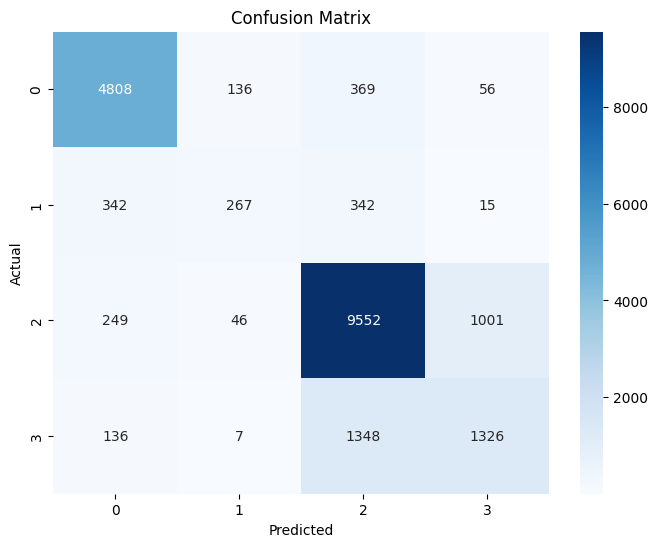

<ipython-input-138-57bd5afde46c>:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


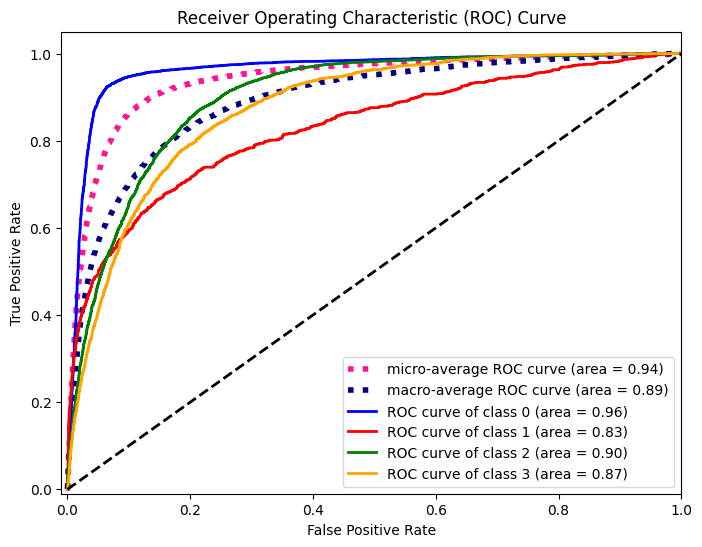

In [138]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)
print(cm)
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Convert y_test and y_pred into binary form
y_test_binarized = label_binarize(y_test_encoded, classes=[0, 1, 2, 3])
y_pred_binarized = hatespeeh_clf.decision_function(X_test)

# Compute ROC curve and ROC area for each class
n_classes = 4
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_binarized.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['blue', 'red', 'green', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Model 2: Using Multinomial Naive Bayes

The accuracy is lesser than that of SVM trained above, so we will not use this model in pipeline. (Don't run the code as result may become different in pipeline. If ran, then again run the above svm code).

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [38]:
# Loading dataset of 100k samples
data_hatespeech = pd.read_csv('/content/hatespeech_100k.csv', encoding='iso-8859-1')
data_hatespeech.head(5)

tweets   labels
0  Beats by Dr. Dre urBeats Wired In-Ear Headphon...     spam
1  RT @Papapishu: Man it would fucking rule if we...  abusive
2  It is time to draw close to Him &#128591;&#127...   normal
3  if you notice me start to act different or dis...   normal
4  Forget unfollowers, I believe in growing. 7 ne...   normal

In [39]:
# Label Distribution of whole dataset
data_hatespeech["labels"].value_counts()

normal     53851
abusive    27150
spam       14030
hateful     4965
Name: labels, dtype: int64

In [40]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_hatespeech['tweets'], data_hatespeech['labels'], test_size=0.2, random_state=42)

In [41]:
# Label Distribution of y_train
y_train.value_counts()

normal     43003
abusive    21781
spam       11213
hateful     3999
Name: labels, dtype: int64

In [42]:
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
X_train = vectorizer.fit_transform(X_train)

In [43]:
le = LabelEncoder()

# Fit the LabelEncoder object to the categorical labels in y_train
le.fit(y_train)

# Transform the categorical labels in y_train to numerical values
y_train_encoded = le.transform(y_train)
y_train_encoded.shape

(79996,)

In [44]:
hatespeeh_clf = MultinomialNB()
hatespeeh_clf.fit(X_train, y_train_encoded)

MultinomialNB()

In [45]:
X_test = vectorizer.transform(X_test)

In [46]:
y_pred = hatespeeh_clf.predict(X_test)

In [47]:
le = LabelEncoder()

le.fit(y_test)

# Transform the categorical labels in y_train to numerical values
y_test_encoded = le.transform(y_test)
y_test_encoded

array([2, 2, 3, ..., 0, 3, 0])

In [48]:
import math
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Model Accuracy: ", math.ceil(accuracy*100))
print(classification_report(y_test_encoded, y_pred))

Model Accuracy:  72
              precision    recall  f1-score   support

           0       0.84      0.67      0.74      5369
           1       0.87      0.04      0.07       966
           2       0.68      0.98      0.81     10848
           3       0.78      0.03      0.06      2817

    accuracy                           0.72     20000
   macro avg       0.79      0.43      0.42     20000
weighted avg       0.75      0.72      0.65     20000



[[ 3574     5  1788     2]
 [  383    34   548     1]
 [  184     0 10641    23]
 [  137     0  2588    92]]


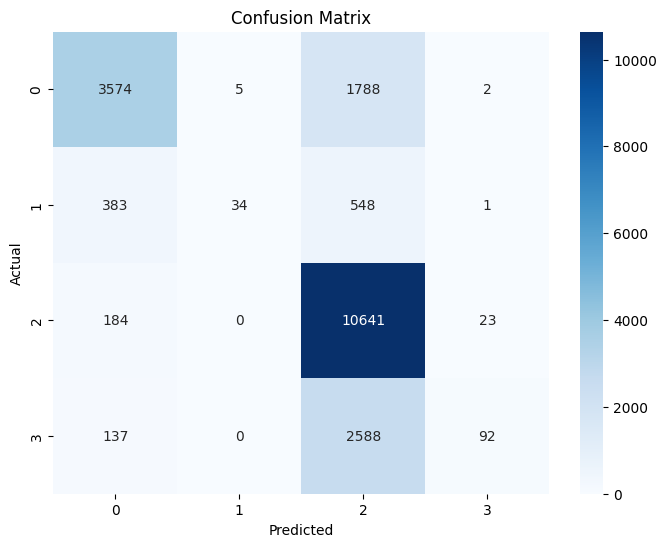

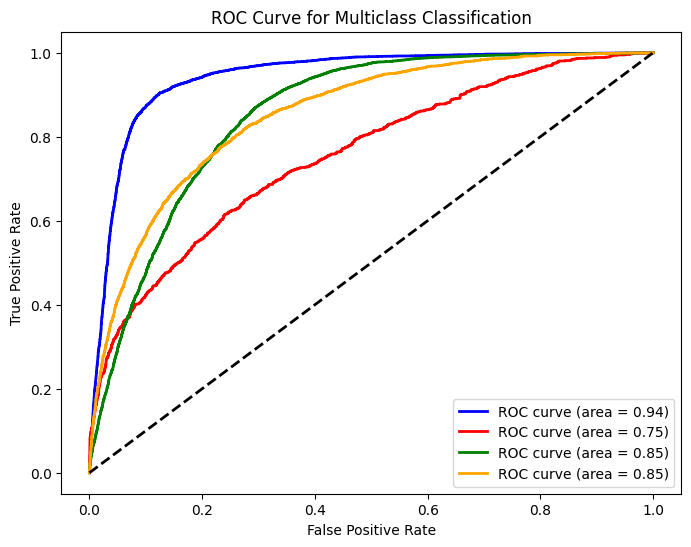

In [49]:
#confusion matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)
print(cm)
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert the test labels to binary form
y_test_bin = label_binarize(y_test_encoded, classes=[0, 1, 2, 3])

# Get the predicted probabilities for each class
y_pred_proba = hatespeeh_clf.predict_proba(X_test)

# Calculate the false positive rate (fpr), true positive rate (tpr), and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Set the axis labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")

# Show the plot
plt.show()

## African American English Data Collection

We will perform same steps for AAE data collection as hatespeech. In this dataset there are 6 columns.
Tweets_IDs: Containing tweet IDs
Timestamp: Time of tweet being posted.

In [ ]:
# Using AAE dataset which contains tweets ID, timestamp and similarity to 4 classes of label. They are AA (African American), Hispanic, Others and White. This is means that tweet is similar to which community more  than others. We can see every tweet have more AA similarity score, though we already know its a AA tweet data.
# We can see the data sample below.
df = pd.read_csv("/content/twitteraae_limited_aa.csv", delimiter = "\t", on_bad_lines='skip')
df.columns = ['Tweet_IDs', 'timestamp', 'AA', 'Hispanic', 'Others', 'White']
print(df.head())

            Tweet_IDs                       timestamp        AA  Hispanic  \
0  288532237186646016  Tue Jan 08 06:27:00 +0000 2013  0.942000  0.058000   
1  289899995472224257  Sat Jan 12 01:01:59 +0000 2013  0.951111  0.031111   
2  289901379869351936  Sat Jan 12 01:07:29 +0000 2013  0.957143  0.034286   
3  289902453367910401  Sat Jan 12 01:11:45 +0000 2013  0.975000  0.010000   
4  290208633545965568  Sat Jan 12 21:28:24 +0000 2013  0.996000  0.000000   

   Others     White  
0     0.0  0.000000  
1     0.0  0.017778  
2     0.0  0.008571  
3     0.0  0.015000  
4     0.0  0.004000  


Some tweets have AA (African American) probabilites above 1. As probabilities cannot be above 1, we discarded those tweets IDs.

In [ ]:
df=df[df["AA"]<=1.0]

We also want the tweets data for our second model to predict the tweet which are most aae in nature, which means some tweets in dataset have more hispanic, others or white probability as well. So we want to consider tweets as AA when the probability of it is more than 0.8. So we added a row called labels and marked tweets as 1 if AA is more than 0.8 and 0 if AA is less 0.8 and less.

In [ ]:
df['labels'] = df['AA'].apply(lambda x: 1 if x > 0.8 else 0)

In [ ]:
# Making list of all the tweets ID so that we can fetch it from twitter API
tweet_IDs_list = df["Tweet_IDs"].values
tweet_IDs_list

array([288532237186646016, 289899995472224257, 289901379869351936, ...,
       295826383567982592, 295854762497294336,         2958553577])

We will fetch 200k tweet text. First 100k will be used to train AAE detection model to predict if tweets is aae in nature and second 100k will be used on pipeline to remove bias from them by using word replacement.

In [ ]:
# Fetching the tweets text associated with the IDs in tweet_IDs_list
df_tweets = pd.DataFrame()
df_tweets['text'] = None
for i, ids in enumerate(tweet_IDs_list):
  if i == 200000:
    break
  try:
    tweet = api.get_status(ids)
    df_tweets.at[i,'text'] = tweet.text
  except:
    print("ID is not valid")
  print(tweet.text)

Man imissed a called from my bae hella mad -_- @callme_KRAZII
ID is not valid
Man imissed a called from my bae hella mad -_- @callme_KRAZII
@devontekthomas I did not mean to say dat
@devontekthomas awww u do too
@devontekthomas wat r u doin boy
@ZariaDove I know dats rite
I'm trying to get tweeter...
Wth......Kenya......lmbo...........next time pic a different event to prove your point............#RHOA
Twrkndathunibun
Mm dis is unusual my phone dry af right
@nakeithiaB lol null jus dont wanna have ya hot and bothered
@nakeithiaB seem like it man
Feel good outside tonight
@JadeTrillOG lol Nall fool jus a guess
"@IAM_SELFMADETY: .* READY TO GET THESE TATS B4 SPRiNG BREAK .!"1000
If u push da right buttons, she gone dance without da bands lol
Datum dryer broke so I'm at dis dry cleaner
Full af
Cooling in da hood
@_HOTWiNGSnHOES mm really
@_HOTWiNGSnHOES so but I got dreads tho ;)
@_HOTWiNGSnHOES wat u sorry for fool
@getMONEY_bb you gone makee come looking for yo lil ass
Off work early
@I

In [ ]:
# Saving the tweets into the csv data for further preprocessing tasks
df_tweets.rename(columns = {'text':'tweets'}, inplace = True)
df_tweets['labels'] = df['labels']
df_tweets.to_csv('aae_200k_data.csv', encoding='utf-8', index=False)

from google.colab import files
files.download('aae_200k_data.csv')

## African American English Data Preprocessing

In [ ]:
# Loading our African American English (AAE) Tweet dataset
data_aae = pd.read_csv("/content/aae_100k_data.csv")
data_aae.head(5)

tweets  labels
0  Click Clack Motha Fucka I ain't tryin to hear ...       1
1  Man imissed a called from my bae hella mad -_-...       1
2  @devontekthomas OMG I keep sayin boo wen I mea...       1
3          @devontekthomas I did not mean to say dat       1
4                      @devontekthomas awww u do too       1

In [ ]:
data_aae.shape

(100000, 2)

##EDA

In [ ]:
import spacy
from textacy import preprocessing
nlp = spacy.load('en_core_web_sm')
from spacy.tokenizer import Tokenizer
import re

In [ ]:
# Regular expression to check for all kinds of emojis and symbols
from collections import defaultdict
import string

regrex_pattern = re.compile(pattern = "["
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
          u"\U00002500-\U00002BEF"  # chinese char
          u"\U00002702-\U000027B0"
          u"\U00002702-\U000027B0"
          u"\U000024C2-\U0001F251"
          u"\U0001f926-\U0001f937"
          u"\U00010000-\U0010ffff"
          u"\u2640-\u2642"
          u"\u2600-\u2B55"
          u"\u200d"
          u"\u23cf"
          u"\u23e9"
          u"\u231a"
          u"\ufe0f"  # dingbats
          u"\u3030"
                            "]+", flags = re.UNICODE)

stopwords_dict = defaultdict(int)
punc = defaultdict(int)
emojis = defaultdict(int)

for tweet in data_aae["tweets"]:

  doc = nlp(tweet)

  
  stopwords = spacy.lang.en.stop_words.STOP_WORDS

  for word in tweet:
    # For Stopwords
    if word in stopwords:
      stopwords_dict[word] += 1
    # For Punct
    if word in string.punctuation:
      punc[word] += 1
    # For Emojis and other symbols'
    check_emojis = re.fullmatch(regrex_pattern, word)
    if check_emojis != None:
      emojis[word] += 1


<BarContainer object of 2 artists>

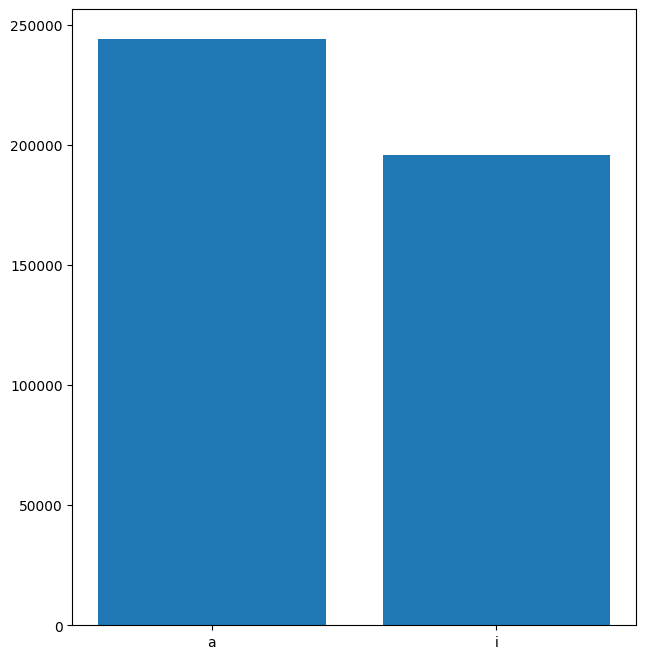

In [ ]:
# Graph for Stopwords
top10_stopwords = sorted(stopwords_dict.items(), key=lambda x:x[1], reverse=True)[:10]
x0,y0 = zip(*top10_stopwords)

plt.figure(1, figsize=(16,8))
plt.subplot(1,2,1)
plt.bar(x0,y0)

<BarContainer object of 10 artists>

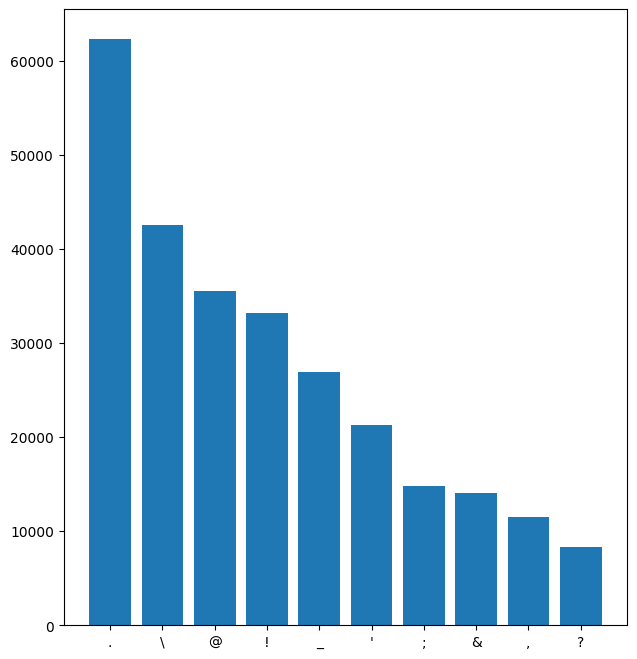

In [ ]:
# Graph for punct
top10_punct = sorted(punc.items(), key=lambda x:x[1], reverse=True)[:10]
x0,y0 = zip(*top10_punct)

plt.figure(1, figsize=(16,8))
plt.subplot(1,2,1)
plt.bar(x0,y0)

<BarContainer object of 10 artists>

/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 128076 (\N{OK HAND SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128076 (\N{OK HAND SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


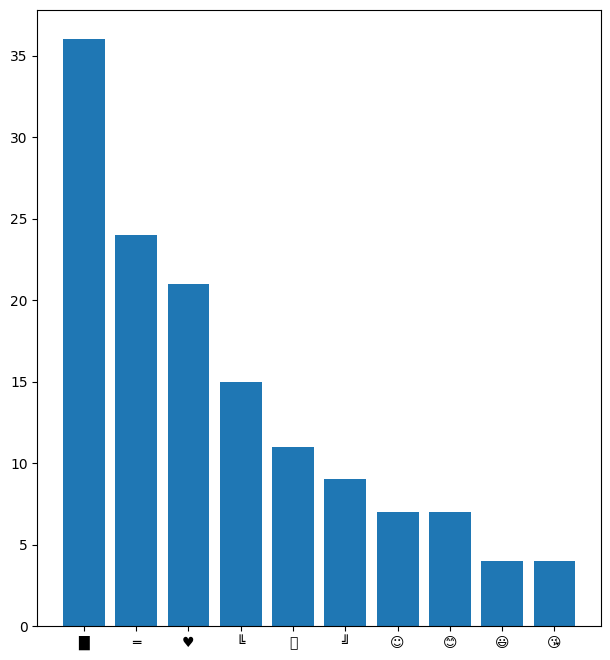

In [ ]:
# Graph for Emojis
top10_emojis = sorted(emojis.items(), key=lambda x:x[1], reverse=True)[:10]
x0,y0 = zip(*top10_emojis)

plt.figure(1, figsize=(16,8))
plt.subplot(1,2,1)
plt.bar(x0,y0)

# Splitting the AAE data

In [ ]:
# Loading our African American English (AAE) Tweet dataset
data_aae = pd.read_csv("/content/aae_100k_data.csv")
data_aae.head(5)

tweets  labels
0  Click Clack Motha Fucka I ain't tryin to hear ...       1
1  Man imissed a called from my bae hella mad -_-...       1
2  @devontekthomas OMG I keep sayin boo wen I mea...       1
3          @devontekthomas I did not mean to say dat       1
4                      @devontekthomas awww u do too       1

In [ ]:
data_aae['labels'].value_counts()

1    85511
0    14489
Name: labels, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_aae['tweets'], data_aae['labels'], test_size=0.2, random_state=42)

In [ ]:
y_train.value_counts()

1    68428
0    11572
Name: labels, dtype: int64

In [ ]:
y_test.value_counts()

1    17083
0     2917
Name: labels, dtype: int64

### Method 1

In this too, we initially applied above logic but the model had same issues as above **(We can Skip to Method 2)**. The model had accuracy of 85% but the precision & recall was only for Label 1 which was a majority class and no values came for Lable 0.

##Tokenization

In [ ]:
"""
Reference: Kabilesh, KabileshKabilesh 98466 gold badges2020 silver badges4646 bronze badges, TimTim 2, NickNick 3, sougata sahasougata saha4766 bronze badges, &amp; toshi456toshi45620311 silver badge77 bronze badges.(1965, September 1). Unable to remove some emojis from tweets in Python. Stack Overflow. Retrieved March 24, 2023, from https://stackoverflow.com/questions/53322870/unable-to-remove-some-emojis-from-tweets-in-python 
Function for emoji removal
"""
# Function to remove the emojis
def remove_emoji(token):
  regrex_pattern = re.compile(pattern = "["
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
          u"\U00002500-\U00002BEF"  # chinese char
          u"\U00002702-\U000027B0"
          u"\U00002702-\U000027B0"
          u"\U000024C2-\U0001F251"
          u"\U0001f926-\U0001f937"
          u"\U00010000-\U0010ffff"
          u"\u2640-\u2642"
          u"\u2600-\u2B55"
          u"\u200d"
          u"\u23cf"
          u"\u23e9"
          u"\u231a"
          u"\ufe0f"  # dingbats
          u"\u3030"
                            "]+", flags = re.UNICODE)
  return regrex_pattern.sub(r'', token)

In [ ]:
# Tokenization (splitting text into individual words), removing stop words, lemmatizing words, and removing emojis, symbols characters.
def tokenize(docs, lemmatized=True, remove_stopword=True, remove_punct = True):
    
    tokenized_docs = []

    for doc in docs:
      doc = nlp(doc)
      doc_tokenized = []

      # Lemmatized
      for token in doc:
        if lemmatized:
          doc_tokenized.append(token.lemma_)
        else:
          doc_tokenized.append(token.text)

      # Removing Noises like @, links and emojis from the tweets
      temp_tokens = []
      for token in doc_tokenized:
        if token.startswith('@') and len(token) > 1:
          token = '@user'
        elif token.startswith('http'):
          token = 'http'
        else:
            token = remove_emoji(token)
        temp_tokens.append(token)
      doc_tokenized = temp_tokens
    
      # Remove Stopwords from the tokens
      if remove_stopword:
        stopwords = spacy.lang.en.stop_words.STOP_WORDS
        doc_tokenized = [token for token in doc_tokenized if str(token).lower() not in stopwords]

      # Removed Punc
      if remove_punct:
        doc_tokenized = " ".join([token for token in doc_tokenized])
        doc_tokenized = nlp(doc_tokenized)
        doc_tokenized = [token for token in doc_tokenized if not token.is_punct]

      # Remove empty tokens and lowercase all tokens
      doc_tokenized = [str(token).lower() for token in doc_tokenized if str(token).strip()]
      tokenized_docs.append(doc_tokenized)

    return tokenized_docs

In [ ]:
tokenized_tweets_train = tokenize(X_train, lemmatized=True, remove_stopword=True, remove_punct = True)
print(len(tokenized_tweets_train))

8000


In [ ]:
tokenized_tweets_test = tokenize(X_test, lemmatized=True, remove_stopword=True, remove_punct = True)
print(len(tokenized_tweets_test))

2000


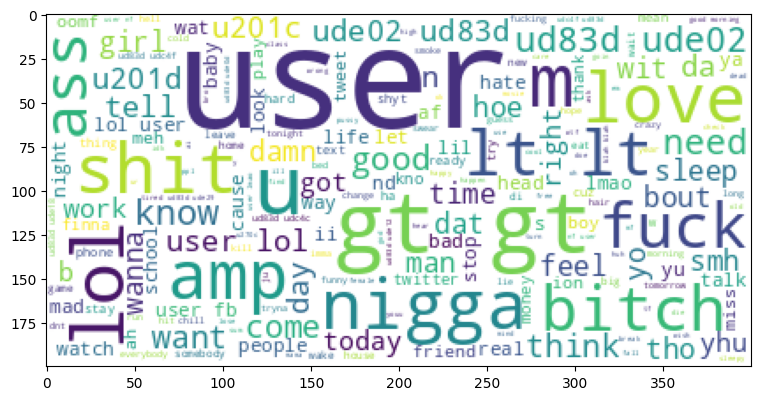

In [ ]:
from wordcloud import WordCloud

all_words = []
for tokenized_tweet in tokenized_tweets_train:
  for word in tokenized_tweet:
    all_words.append(word)
word_cloud = WordCloud(background_color="white", max_font_size=80).generate(" ".join(all_words))
plt.figure(1, figsize=(20, 18))
plt.subplot(1,2,1)
plt.imshow(word_cloud)

Normalization for train data aae

In [ ]:
# using dictionary comprehension for iteration
tokenized_tweets_dict = {idx : tokenized_tweets_train[idx] for idx in range(len(tokenized_tweets_train))}

# Find the count of each unique token and save the count as a dictionary, named word_dict, i.e., {world: 1, a: 1, ...}
from collections import Counter
for i, para in enumerate(tokenized_tweets_dict.values()):
  word_dict = dict(Counter(para))
  tokenized_tweets_dict[i] = word_dict

print(tokenized_tweets_dict)

{0: {'slick': 1}, 1: {'nf': 1, '@user': 1}, 2: {'@user': 1, 'lol': 1, 'money': 2, 'fuss': 1}, 3: {'@user': 1, 'fb': 1}, 4: {'@user': 1, 'beautiful': 1, 'want': 1, 'know': 1}, 5: {'@user': 1, 'dam': 1, 'yea': 1, 'leave': 1}, 6: {'\\u201c@wolfpackalan': 1, 'touch': 1, 'iphone': 1, 'usphone': 1, 'wephone': 1, 'ourphone': 1, 'iphone.\\u201dwaab': 1}, 7: {'shout': 1, 'nestboy': 1, 'vick': 1, 'cold': 1, 'n': 1, 'rapping': 1, 'sht': 1, 'drop.n': 1, 'track': 1, 'm': 1, 'em': 1}, 8: {'communication': 1}, 9: {'@user': 1, 'email': 1}, 10: {'@user': 1, 'goodnight': 1, 'btw': 1, 'fb': 1, 'n': 1, 'sweetdreams': 1}, 11: {'yo': 1, 'tyren': 1, 'friend': 1}, 12: {'amp': 1, 'thang': 1}, 13: {'tf': 1, 'corduroy': 1, 'goin': 1, 'beyonce': 1, 'blue': 3, 'ivy': 1, 'bust': 1, 'crayon': 1, 'etc': 1, 'dtfl': 1}, 14: {'wizard': 1, 'lastnight': 1, '@user': 1}, 15: {'@user': 1, 'prob': 1, 'hun': 1, 'dimple': 1}, 16: {'tell': 1, 'love': 1, 'lose': 1, 'lbs': 1}, 17: {'gateway': 1, 'downtown': 1, 'close': 1}, 18: {'\

The unique words will remain same as hatespeech model as for aae model too the matrix shape should be same when using the model in the pipeline.

In [ ]:
# Creates a numpy array, say dtm with a shape (# of tokenized_tweets_dict x # of unique words), and set the initial values to 0.
dtm = np.zeros((len(tokenized_tweets_dict.keys()), len(unique_words)))
dtm.shape

(8000, 86280)

In [ ]:
import scipy.sparse as sp

# Create a sparse matrix with the same shape as dtm
sparse_dtm = sp.lil_matrix(dtm.shape)

# Fill in the matrix using the same logic as before
for i, j in enumerate(sparse_dtm.rows):
    for k in range(len(j)):
        if unique_words[k] in tokenized_tweets_dict[i]:
            sparse_dtm[i, k] = tokenized_tweets_dict[i][unique_words[k]]

In [ ]:
import numpy as np

# Convert dtm to a sparse matrix
sparse_dtm = sp.csr_matrix(dtm)

# Calculates the paragraph frequency for each word
k = sp.csr_matrix(sparse_dtm > 0, dtype=int)
df = np.array(k.sum(axis=0))[0]

# Normalizes the word count per paragraph, adding a minute constant to the denominator to avoid dividing by zero.
eps = 1e-10
normalized_dtm = sparse_dtm.multiply(1 / (sparse_dtm.sum(axis=1) + eps))

normalized_dtm

<8000x86280 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in COOrdinate format>

## Tf/Idf

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

# Instantiate the TfidfTransformer with smooth_idf=True to avoid dividing by zero
tfidf_transformer = TfidfTransformer(smooth_idf=True)

# Apply the TF-IDF transformation to the normalized DTM
tfidf_matrix = tfidf_transformer.fit_transform(normalized_dtm)

# Convert the sparse matrix to a dense numpy array for easier manipulation
dense_tfidf_matrix = tfidf_matrix.toarray()

# Print the shape of the dense TF-IDF matrix
print(dense_tfidf_matrix.shape)

(8000, 86280)


In [ ]:
y_train

9254    1
1561    1
1670    1
6087    1
6669    0
       ..
5734    1
5191    1
5390    1
860     1
7270    1
Name: labels, Length: 8000, dtype: int64

In [ ]:
from sklearn.svm import SVC
clfAAE = SVC()
clfAAE.fit(dense_tfidf_matrix, y_train)

SVC()

Normalization of test data for aae

In [ ]:
# using dictionary comprehension for iteration
tokenized_tweets_dict = {idx : tokenized_tweets_test[idx] for idx in range(len(tokenized_tweets_test))}

# Find the count of each unique token and save the count as a dictionary, named word_dict, i.e., {world: 1, a: 1, ...}
from collections import Counter
for i, para in enumerate(tokenized_tweets_dict.values()):
  word_dict = dict(Counter(para))
  tokenized_tweets_dict[i] = word_dict

print(tokenized_tweets_dict)

{0: {'flip': 1, 'lifetime': 1, 'movie': 1, 'mobwive': 1, 'rhoa': 1}, 1: {'watch': 1, 'game': 1, 'wit': 1, 'grandad': 1, '\\ud83d\\udc4d\\ud83d\\udc4d\\ud83d\\udc4d': 1}, 2: {'@user': 1, 'fb': 1}, 3: {'friend': 1, 'yhu': 1, 'fat': 1}, 4: {'shyt': 1, 'ii': 1, 'blind': 1, 'self': 1}, 5: {'twitter': 1, 'wat': 1, 'poppin': 1}, 6: {'probably': 1, 'answer': 1, 'email': 1}, 7: {'@user': 1, 'knooooooow': 1}, 8: {'damnhe': 1, 'rock': 1, 'shit': 1}, 9: {'@user': 2, 'suppose': 1, 'joke': 1, 'funny': 1, 'luck': 1, 'time': 1}, 10: {'wus': 1, 'bout': 2, 'tooh': 5, 'sleep': 1, 'butt': 1, 'ii': 1, 'talkin': 2, 'q': 1, 'sum': 1, 'stuff': 1, 'nii': 1, 'um': 2, 'uph': 1, 'thankin': 1, 'nn': 1, 'bored': 1, 'halle': 1, 'doe': 1, 'gt;&gt': 1, 'love': 1}, 11: {'asap': 1, 'rocky': 1, 'joint': 1, 'hard': 1}, 12: {'wrong': 1, '@user': 1, 'love': 1}, 13: {'\\verbal': 1, 'assassin': 1, 'architect': 1, 'hell': 1, 'snuff': 1, 'jesus,\\"-': 1, 'nas': 1}, 14: {'@user': 1, 'bouta': 1, 'bad': 1}, 15: {'@user': 1, 'm': 1

In [ ]:
# Creates a numpy array, say dtm with a shape (# of tokenized_tweets_dict x # of unique words), and set the initial values to 0.
dtm = np.zeros((len(tokenized_tweets_dict.keys()), len(unique_words)))
dtm.shape

(2000, 86280)

In [ ]:
import scipy.sparse as sp

# Create a sparse matrix with the same shape as dtm
sparse_dtm = sp.lil_matrix(dtm.shape)

# Fill in the matrix using the same logic as before
for i, j in enumerate(sparse_dtm.rows):
    for k in range(len(j)):
        if unique_words[k] in tokenized_tweets_dict[i]:
            sparse_dtm[i, k] = tokenized_tweets_dict[i][unique_words[k]]

In [ ]:
import numpy as np

# Convert dtm to a sparse matrix
sparse_dtm = sp.csr_matrix(dtm)

# Calculates the paragraph frequency for each word
k = sp.csr_matrix(sparse_dtm > 0, dtype=int)
df = np.array(k.sum(axis=0))[0]

# Normalizes the word count per paragraph, adding a minute constant to the denominator to avoid dividing by zero.
eps = 1e-10
normalized_dtm = sparse_dtm.multiply(1 / (sparse_dtm.sum(axis=1) + eps))

normalized_dtm

<2000x86280 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in COOrdinate format>

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

# Instantiate the TfidfTransformer with smooth_idf=True to avoid dividing by zero
tfidf_transformer = TfidfTransformer(smooth_idf=True)

# Apply the TF-IDF transformation to the normalized DTM
tfidf_matrix = tfidf_transformer.fit_transform(normalized_dtm)

# Convert the sparse matrix to a dense numpy array for easier manipulation
dense_tfidf_matrix = tfidf_matrix.toarray()

# Print the shape of the dense TF-IDF matrix
print(dense_tfidf_matrix.shape)

(2000, 86280)


In [ ]:
# Evaluate the model on the testing data
y_pred = clfAAE.predict(dense_tfidf_matrix)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Calculate the accuracy of the model on the validation set
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy in percentage: {:.2f}%".format(accuracy * 100))
# Printing Classification Report
print(classification_report(y_test, y_pred))

Accuracy in percentage: 85.45%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       291
           1       0.85      1.00      0.92      1709

    accuracy                           0.85      2000
   macro avg       0.43      0.50      0.46      2000
weighted avg       0.73      0.85      0.79      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Method 2
In this we used same Method 2 approach as hatespeech model. We trained 1st using MultinomialNB and than secondly using SVM.

As the our target is to identify 1s ie. aae so both model have similar f1 score for that.

Furthermore, the MultinomialNB model has a higher weighted-average precision and accuracy compared to the SVM model. This indicates that the NB model is better at predicting the correct class overall, taking into account the class imbalance in the dataset.

**So we are going with 1st model, in this case which is trained with MultinomialNB() as it also have higher precision for 1 and both model have same f1 score for that matter i.e. 92, and predicting 1 accurately is our priority.**

Model 1: MultinomialNB

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

In [98]:
# Loading dataset of 100k samples
data_aae = pd.read_csv('/content/aae_100k_data.csv', encoding='iso-8859-1')
data_aae.head(5)

tweets  labels
0  Click Clack Motha Fucka I ain't tryin to hear ...       1
1  Man imissed a called from my bae hella mad -_-...       1
2  @devontekthomas OMG I keep sayin boo wen I mea...       1
3          @devontekthomas I did not mean to say dat       1
4                      @devontekthomas awww u do too       1

In [99]:
data_aae["labels"].value_counts()

1    85511
0    14489
Name: labels, dtype: int64

In [100]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_aae['tweets'], data_aae['labels'], test_size=0.2, random_state=42)

In [101]:
y_train.value_counts()

1    68428
0    11572
Name: labels, dtype: int64

In [102]:
X_train = vectorizer.transform(X_train)

In [103]:
y_train

75220    1
48955    1
44966    1
13568    1
92727    1
        ..
6265     1
54886    1
76820    0
860      1
15795    1
Name: labels, Length: 80000, dtype: int64

In [104]:
aae_clf = MultinomialNB()
aae_clf.fit(X_train, y_train)

MultinomialNB()

In [105]:
X_test = vectorizer.transform(X_test)

In [106]:
y_pred = aae_clf.predict(X_test)

In [107]:
import math
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy: ", math.ceil(accuracy*100))
print(classification_report(y_test, y_pred))

Model Accuracy:  86
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      2917
           1       0.85      1.00      0.92     17083

    accuracy                           0.85     20000
   macro avg       0.93      0.50      0.46     20000
weighted avg       0.88      0.85      0.79     20000



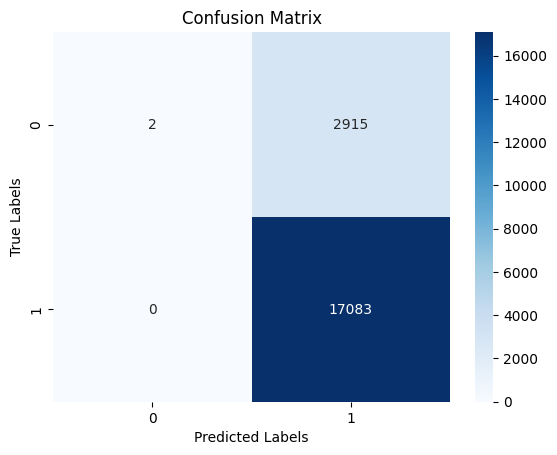

Confusion Matrix:
 [[    2  2915]
 [    0 17083]]


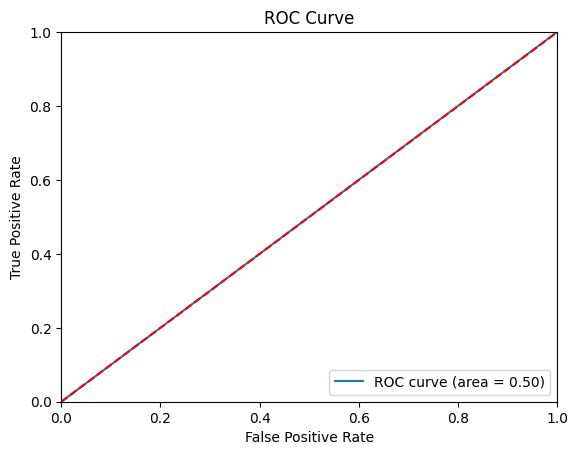

In [108]:
# Get the predictions for the test set
y_pred = aae_clf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Print confusion matrix
print("Confusion Matrix:\n", cm)



from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], '--', color='r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Model 2: SVM

Skip this model as we are using above model (MultinomialNB) in pipeline.

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [73]:
# Loading dataset of 100k samples
data_aae = pd.read_csv('/content/aae_100k_data.csv', encoding='iso-8859-1')
data_aae.head(5)

tweets  labels
0  Click Clack Motha Fucka I ain't tryin to hear ...       1
1  Man imissed a called from my bae hella mad -_-...       1
2  @devontekthomas OMG I keep sayin boo wen I mea...       1
3          @devontekthomas I did not mean to say dat       1
4                      @devontekthomas awww u do too       1

In [74]:
data_aae["labels"].value_counts()

1    85511
0    14489
Name: labels, dtype: int64

In [75]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_aae['tweets'], data_aae['labels'], test_size=0.2, random_state=42)

In [76]:
y_train.value_counts()

1    68428
0    11572
Name: labels, dtype: int64

In [77]:
X_train = vectorizer.transform(X_train)

In [78]:
aae_clf = svm.LinearSVC()
aae_clf.fit(X_train, y_train)

LinearSVC()

In [79]:
X_test = vectorizer.transform(X_test)

In [80]:
y_pred = aae_clf.predict(X_test)

In [81]:
import math
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy: ", math.ceil(accuracy*100))
print(classification_report(y_test, y_pred))

Model Accuracy:  86
              precision    recall  f1-score   support

           0       0.46      0.11      0.18      2917
           1       0.87      0.98      0.92     17083

    accuracy                           0.85     20000
   macro avg       0.66      0.55      0.55     20000
weighted avg       0.81      0.85      0.81     20000



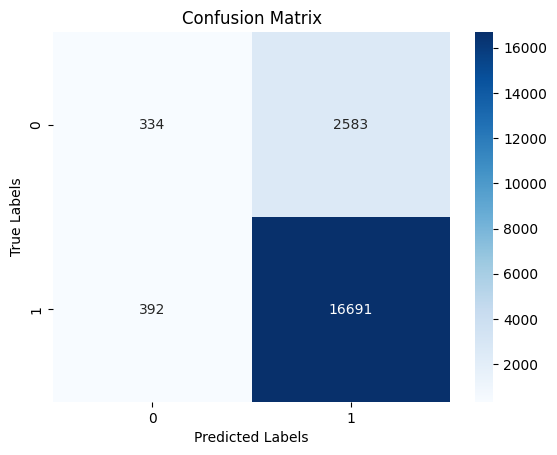

Confusion Matrix:
 [[  334  2583]
 [  392 16691]]


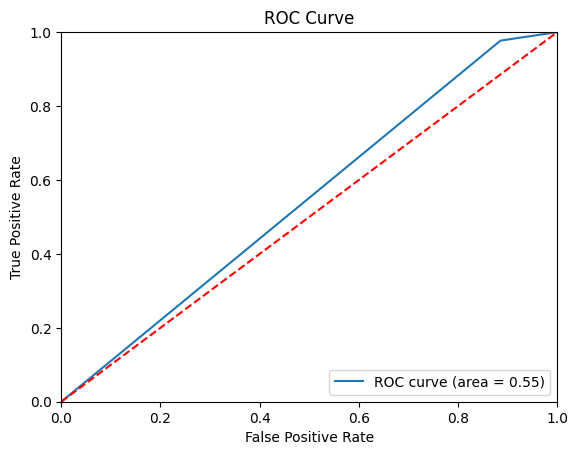

In [82]:
#confusion matrix

import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the predictions for the test set
y_pred = aae_clf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Print confusion matrix
print("Confusion Matrix:\n", cm)


from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], '--', color='r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Sentiment Analysis

We did sentiment Analysis on aae as we want to find how negative or positive the sentiment of the tweets were. This will later help us to justify the hypothesis.

In [ ]:
def compute_sentiment(tweets_tokens, pos, neg ):
    
    result = None
    
    set_pos = set(pos)
    set_neg = set(neg)

    def func(text):
      posi = 0
      nega = 0
      for i in text:
        word = i.text
        if word in set_pos:
          posi += 1
        elif word in set_neg:
          nega += 1
      return (posi-nega)/(posi+nega) if (posi+nega) > 0 else 0 

    new = pd.DataFrame({"aae_tweets_tokens": tweets_tokens})
    new["aae_sentiment"] = new["aae_tweets_tokens"].apply(func)
    result = new[["aae_sentiment"]]

    return result

In [ ]:
pos = pd.read_csv("/content/positive-words.txt", header = None)
pos.head()

0
0         a+
1     abound
2    abounds
3  abundance
4   abundant

In [ ]:
neg = pd.read_csv("/content/negative-words.txt", header = None)
neg.head()

0
0     2-faced
1     2-faces
2    abnormal
3     abolish
4  abominable

In [ ]:
tweets_tokens = tokenize(data_aae['tweets'], lemmatized=True, remove_stopword=True, remove_punct = True)

In [ ]:
result = compute_sentiment(tweets_tokens, 
                           pos[0].values,
                           neg[0].values)
result.head(500)

aae_sentiment
0              0.0
1             -1.0
2              0.0
3              0.0
4              0.0
..             ...
495            0.0
496           -1.0
497            0.0
498           -1.0
499            0.0

[500 rows x 1 columns]

In [ ]:
# Count number of positive, negative, and zero sentiment values
num_neg = 0
num_pos = 0
num_zero = 0
for i, row in result.iterrows():
  num_pos += 1 if  row["aae_sentiment"]>0 else 0
  num_neg += 1 if row["aae_sentiment"]<0 else 0
  num_zero += 1 if row["aae_sentiment"] == 0 else 0

# Print the counts
print("Number of positive sentiment values:", num_pos)
print("Number of negative sentiment values:", num_neg)
print("Number of zero sentiment values:", num_zero)


Number of positive sentiment values: 15484
Number of negative sentiment values: 24932
Number of zero sentiment values: 59584


From this we can see there are 24932 tweets which have negative sentiments. This gives us the sentiment prospective of the dataset.

##Training The Word2Vec Model and Replacment

**Approach applied in Word Replacement Model and creating the replacement dicionary:**

1) Firstly, we train the word2Vec model on our entire AAE dataset.

2) Then, we loop through the entire dataset and pick out the closest replacement word which are mentioned in the LIWC dictionary. LIWC is a swear word dictionary. The word2Vec model provides us with a list of similar words.

3) While searching for the closest word from the similar words list, we check again if the closest word is in the LIWC library. If it is, we choose another word from the similar words list and repeat the process until we find a safe word. We also check that the suggested word is not a substring or in any form of bad words. For example, if LIWC has the word "Fucked," and we encounter the word "Fuck," which is a substring of "Fucked," we reject those similar words as well. Because of this we are able to remove many more abbreviations of the same word.

4) Finally, we generate a JSON list that is mapped with all the controversial words as keys and their corresponding safe words as values.

**For Example: {"niggers": "coughs", "fucks": "dealing", "fucking": "playing"}**

In [ ]:
import pandas as pd
import gensim
df = pd.read_csv("/content/twitteraae_all_aa", delimiter="\t",on_bad_lines = 'warn', names = ["Tweet_id", "Tweet_timestamps","user_ids","tweet_co-ordinates", "tweet_census_block", "tweet_text","Pb_aa", "pb_hispanic", "pb_other", "pb_white"])
df.head()

Skipping line 396: expected 10 fields, saw 14
Skipping line 1710: expected 10 fields, saw 14
Skipping line 3274: expected 10 fields, saw 14
Skipping line 4371: expected 10 fields, saw 14
Skipping line 6752: expected 10 fields, saw 14
Skipping line 8090: expected 10 fields, saw 14
Skipping line 8124: expected 10 fields, saw 14
Skipping line 8126: expected 10 fields, saw 14
Skipping line 8147: expected 10 fields, saw 14
Skipping line 8362: expected 10 fields, saw 14
Skipping line 8370: expected 10 fields, saw 14
Skipping line 8376: expected 10 fields, saw 14
Skipping line 8382: expected 10 fields, saw 14
Skipping line 9538: expected 10 fields, saw 14
Skipping line 9540: expected 10 fields, saw 14
Skipping line 9624: expected 10 fields, saw 18
Skipping line 9631: expected 10 fields, saw 14
Skipping line 9633: expected 10 fields, saw 14
Skipping line 11811: expected 10 fields, saw 14
Skipping line 11817: expected 10 fields, saw 18
Skipping line 11828: expected 10 fields, saw 14
Skipping li

Tweet_id                Tweet_timestamps    user_ids  \
0  293846693215096832  Tue Jan 22 22:24:45 +0000 2013  1028920752   
1  288532237186646016  Tue Jan 08 06:27:00 +0000 2013  1040150983   
2  289899995472224257  Sat Jan 12 01:01:59 +0000 2013  1068611971   
3  289901379869351936  Sat Jan 12 01:07:29 +0000 2013  1068611971   
4  289902453367910401  Sat Jan 12 01:11:45 +0000 2013  1068611971   

            tweet_co-ordinates  tweet_census_block  \
0  [-80.01040975, 32.80108357]        4.501900e+11   
1     [-87.322161, 41.6006888]        1.808901e+11   
2    [-78.85113963, 42.909513]        3.602900e+11   
3   [-78.8510475, 42.90955088]        3.602900e+11   
4  [-78.85107559, 42.90955579]        3.602900e+11   

                                          tweet_text     Pb_aa  pb_hispanic  \
0  Click Clack Motha Fucka I ain't tryin to hear ...  0.894545     0.016364   
1  Man imissed a called from my bae hella mad -_-...  0.942000     0.058000   
2  @devontekthomas OMG I keep sayin boo wen I mea...  0.951111     0.031111   
3          @devontekthomas I did not mean to say dat  0.957143     0.034286   
4                      @devontekthomas awww u do too  0.975000     0.010000   

   pb_other  pb_white  
0       0.0  0.089091  
1       0.0  0.000000  
2       0.0  0.017778  
3       0.0  0.008571  
4       0.0  0.015000

In [ ]:
df.shape

(1146847, 10)

In [ ]:
new_df=df[df["Pb_aa"]<1.0]

In [ ]:
final_data = new_df[new_df["Pb_aa"]>.9]
final_data

Tweet_id                Tweet_timestamps    user_ids  \
1        288532237186646016  Tue Jan 08 06:27:00 +0000 2013  1040150983   
2        289899995472224257  Sat Jan 12 01:01:59 +0000 2013  1068611971   
3        289901379869351936  Sat Jan 12 01:07:29 +0000 2013  1068611971   
4        289902453367910401  Sat Jan 12 01:11:45 +0000 2013  1068611971   
5        290208633545965568  Sat Jan 12 21:28:24 +0000 2013  1068611971   
...                     ...                             ...         ...   
1146833  410464370817122304  Tue Dec 10 17:41:46 +0000 2013    66064292   
1146834  410952847959019520  Thu Dec 12 02:02:48 +0000 2013    66064292   
1146838  411152630749339648  Thu Dec 12 15:16:40 +0000 2013   706008535   
1146841  409187070851448832  Sat Dec 07 05:06:14 +0000 2013   831230790   
1146846  409054967132336128  Fri Dec 06 20:21:18 +0000 2013   990654176   

                  tweet_co-ordinates  tweet_census_block  \
1           [-87.322161, 41.6006888]        1.808901e+11   
2          [-78.85113963, 42.909513]        3.602900e+11   
3         [-78.8510475, 42.90955088]        3.602900e+11   
4        [-78.85107559, 42.90955579]        3.602900e+11   
5        [-78.85091984, 42.90915702]        3.602900e+11   
...                              ...                 ...   
1146833    [-75.1716975, 39.9919655]        4.210102e+11   
1146834    [-75.1716978, 39.9919641]        4.210102e+11   
1146838   [-74.20753657, 40.7758822]        3.401301e+11   
1146841  [-86.86103941, 33.51142617]        1.073003e+10   
1146846     [-92.2886571, 34.729104]        5.119005e+10   

                                                tweet_text     Pb_aa  \
1        Man imissed a called from my bae hella mad -_-...  0.942000   
2        @devontekthomas OMG I keep sayin boo wen I mea...  0.951111   
3                @devontekthomas I did not mean to say dat  0.957143   
4                            @devontekthomas awww u do too  0.975000   
5                         @devontekthomas wat r u doin boy  0.996000   
...                                                    ...       ...   
1146833  I been playing the nice roll to long now .. 2m...  0.946250   
1146834                     @_doobees awe how was work bby  0.968000   
1146838                Bumpin meek mill while doin my work  0.914286   
1146841  Congratulations, Alpha Kappa Alpha sorors of I...  0.936364   
1146846  I SEE HOES TRYNA LEAVE OUT OF 2013 WIT A GOOD ...  0.995385   

         pb_hispanic  pb_other  pb_white  
1           0.058000  0.000000  0.000000  
2           0.031111  0.000000  0.017778  
3           0.034286  0.000000  0.008571  
4           0.010000  0.000000  0.015000  
5           0.000000  0.000000  0.004000  
...              ...       ...       ...  
1146833     0.006250  0.000000  0.047500  
1146834     0.004000  0.000000  0.028000  
1146838     0.065714  0.000000  0.020000  
1146841     0.000000  0.000000  0.063636  
1146846     0.000000  0.004615  0.000000  

[548516 rows x 10 columns]

In [ ]:
final_data = final_data['tweet_text']

In [ ]:
final_data

1          Man imissed a called from my bae hella mad -_-...
2          @devontekthomas OMG I keep sayin boo wen I mea...
3                  @devontekthomas I did not mean to say dat
4                              @devontekthomas awww u do too
5                           @devontekthomas wat r u doin boy
                                 ...                        
1146833    I been playing the nice roll to long now .. 2m...
1146834                       @_doobees awe how was work bby
1146838                  Bumpin meek mill while doin my work
1146841    Congratulations, Alpha Kappa Alpha sorors of I...
1146846    I SEE HOES TRYNA LEAVE OUT OF 2013 WIT A GOOD ...
Name: tweet_text, Length: 548516, dtype: object

In [ ]:
#preprocessing and cleaning the text data that has to be trained
review_text = final_data.apply(gensim.utils.simple_preprocess)

In [ ]:
review_text

1          [man, imissed, called, from, my, bae, hella, m...
2          [devontekthomas, omg, keep, sayin, boo, wen, m...
3             [devontekthomas, did, not, mean, to, say, dat]
4                            [devontekthomas, awww, do, too]
5                           [devontekthomas, wat, doin, boy]
                                 ...                        
1146833    [been, playing, the, nice, roll, to, long, now...
1146834                           [awe, how, was, work, bby]
1146838          [bumpin, meek, mill, while, doin, my, work]
1146841    [congratulations, alpha, kappa, alpha, sorors,...
1146846    [see, hoes, tryna, leave, out, of, wit, good, ...
Name: tweet_text, Length: 548516, dtype: object

In [ ]:
#loading the model
model = gensim.models.Word2Vec(
    window=10,
    min_count=2,
    workers=4,
)

In [ ]:
#Building vocab
model.build_vocab(review_text, progress_per=1000)

In [ ]:
#training the word2vec model
model.train(review_text, total_examples=model.corpus_count, epochs=model.epochs)

(16878032, 21629045)

In [ ]:
# Giving us similar word list
model.wv.most_similar("man")

[('dude', 0.6268045902252197),
 ('swear', 0.5940654873847961),
 ('boy', 0.5791773200035095),
 ('nigga', 0.5745884776115417),
 ('lady', 0.5740349292755127),
 ('woman', 0.504012405872345),
 ('life', 0.49301663041114807),
 ('guy', 0.4909552037715912),
 ('girl', 0.4802725315093994),
 ('mane', 0.4733762741088867)]

In [ ]:
model.wv.most_similar("nigga")

[('bitch', 0.7739185094833374),
 ('hoe', 0.6884961724281311),
 ('nicca', 0.6871207356452942),
 ('niggas', 0.6610107421875),
 ('niggah', 0.6452218890190125),
 ('boy', 0.6368328332901001),
 ('mans', 0.6208705902099609),
 ('mf', 0.6134971380233765),
 ('shit', 0.601776659488678),
 ('niqqa', 0.5997782945632935)]

Optional (To save the model)

In [ ]:
model.save("./word2vec-twitter.model")

In [ ]:
from google.colab import files

# Download the model file
files.download('word2vec-twitter.model')

Creating the Replacement Dict (conept explained above in algorithm)

In [ ]:
replace_dict = {}

with open("/content/LIWC_swear_dictionary.txt") as f:
  lines = f.readlines()
  word_set = set([l.split()[0] for l in lines])

for key in word_set:
  try:
    val = model.wv.most_similar(key)[0][0]
    i = 1
    while val in key or key in val or val in word_set:
      val = model.wv.most_similar(key)[i][0]
      i += 1
    replace_dict[key]=val
      
  except (KeyError, IndexError):
    pass

In [ ]:
import json
with open("word2vec-twitter-replacement-dict.json","w") as f:
  json.dump(replace_dict,f)

In [ ]:
from google.colab import files

# Download the model file
files.download('word2vec-twitter-replacement-dict.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Desiging Pipeline

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [110]:
# Loading the another half of 100k aae dataset
check_bias_data = pd.read_csv("/content/100k_unseen_aae.csv")
check_bias_data.head()

tweets  labels
0                                               ugh.       0
1  @Quon_Doe ummm, you can get some starburst or ...       0
2  bitch tweeting and shit and couldn't even send...       1
3                                I miss being at 108       0
4                                          ohh shit.       1

In [111]:
import json
# Loading the word replacement dict created in word replacement section.
# Assuming your JSON dictionary is stored in a file named "word2vec-twitter-replacement-dict"
with open('/content/word2vec-twitter-replacement-dict.json', 'r') as f:
    replacement_dict = json.load(f)
replacement_dict

{'cunt': 'gada',
 'vag': 'fout',
 'gooch': 'soulnyi',
 'assholes': 'attitudes',
 'fools': 'hxess',
 'rat': 'clown',
 'scum': 'claps',
 'fuckup': 'basedgoddd_',
 'wop': 'rumah',
 'shiz': 'leannesealey',
 'evilman': 'sons',
 'dickhead': 'cristian',
 'bitchass': 'killed_yalove',
 'nigger': 'theonlyreed',
 'dildo': 'i_behoekilling',
 'shiznit': 'elbowed',
 'maniac': 'myyyyyy',
 'fucking': 'playing',
 'mofo': 'theejewel',
 'lunatics': 'helpn',
 'punanny': 'redd',
 'jackass': 'myprettysmilee',
 'shit': 'shyt',
 'niggers': 'coughs',
 'cowards': 'freakss',
 'faggot': 'punkk',
 'blow': 'roll',
 'devil': 'cops',
 'cooter': 'gurley',
 'bitchy': 'picky',
 'poon': 'republic',
 'dicksucker': 'imissyouu',
 'wank': 'bitch_immehh',
 'goddamnit': 'flashbacks',
 'heck': 'villian_foe',
 'sucker': 'marijuana_lungs',
 'dumass': 'ringg',
 'dicksucking': 'bugging',
 'idiots': 'mygawd',
 'hoe': 'thot',
 'porch': 'couch',
 'nuts': 'pants',
 'dookie': 'bruhhhhhh',
 'boo': 'babe',
 'wierdo': 'sapphire_',
 'goddam

##Algorithm for pipeline

Some initializations:

replaced_word_count: Keep count of replaced words in pipeline

hate_or_abusive_tweet_count: keep count of tweet that were predicted as hateful or absusive by hatespeech model (Model 1)

aae_tweet_count: keep count of tweet predicted as aae by aae detector model (Model 2)

hate_or_abusive_and_aae_tweet: append the tweets which are predicted as hateful or abusive and also aae.

new_replaced_tweet_sentence: append the sentences which are predicted as hateful or abusive and also aae, after replacement.

**for loop on tweets:**

    Model1 (Main Model): check if tweet is hate or abusive. Also increment hate_or_abusive tweet counter by 1 if tweet are hate or abusive.

    Model2 (Diversity Model): check if tweet is aae (African American english). Also increment aae_tweet counter if its aae. Also add tweet to hate_or_abusive_and_aae_tweet list.

    Model3 (Word2Vec):loop through tweet tokens and do word replace if word in replacement_dict.


**For loop Ends**


**Finally, take both hate_or_abusive_tweet list and  new_replaced_tweet_sentence list and first again do prediction on hate_or_abusive_tweet list which comes out to be 0 (abusive) or 1 (hateful). Then use new_replaced_tweet_sentence list which has corresponding tweets of hate_or_abusive_tweet list but with words replaced. Then apply model 1 to check which tweets have became normal after replacement.**


In [112]:
# Initializations
hate_or_abusive_tweet_count = 0
hate_or_abusive_and_aae_tweet = []
aae_tweet = 0
replaced_word_count = 0
new_replaced_tweet_sentence = []
i=0

In [113]:
aae_unseen_tweets = check_bias_data["tweets"]
aae_unseen_tweets

0                                                      ugh.
1         @Quon_Doe ummm, you can get some starburst or ...
2         bitch tweeting and shit and couldn't even send...
3                                       I miss being at 108
4                                                 ohh shit.
                                ...                        
99996     Y dont u trust me I been real since day 1 nd I...
99997                           Y isnt she tlkn to me -___-
99998     Communication is the key &gt;&gt;&gt;&gt;&gt; ...
99999     Baby girl u kno im always here wen ur ready to...
100000               I think bout u all the time baby &lt;3
Name: tweets, Length: 100001, dtype: object

In [114]:
# transform the aae_unseen_tweets on initial vector used to train the hatespeech model as vocab (shape) have to remain same.
aae_unseen_tdidf = vectorizer.transform(aae_unseen_tweets)

In [115]:
"""
Reference: Kabilesh, KabileshKabilesh 98466 gold badges2020 silver badges4646 bronze badges, TimTim 2, NickNick 3, sougata sahasougata saha4766 bronze badges, &amp; toshi456toshi45620311 silver badge77 bronze badges.(1965, September 1). Unable to remove some emojis from tweets in Python. Stack Overflow. Retrieved March 24, 2023, from https://stackoverflow.com/questions/53322870/unable-to-remove-some-emojis-from-tweets-in-python 
Function for emoji removal
"""
# Function to remove the emojis
def remove_emoji(token):
  regrex_pattern = re.compile(pattern = "["
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
          u"\U00002500-\U00002BEF"  # chinese char
          u"\U00002702-\U000027B0"
          u"\U00002702-\U000027B0"
          u"\U000024C2-\U0001F251"
          u"\U0001f926-\U0001f937"
          u"\U00010000-\U0010ffff"
          u"\u2640-\u2642"
          u"\u2600-\u2B55"
          u"\u200d"
          u"\u23cf"
          u"\u23e9"
          u"\u231a"
          u"\ufe0f"  # dingbats
          u"\u3030"
                            "]+", flags = re.UNICODE)
  return regrex_pattern.sub(r'', token)

In [116]:
# Tokenization (splitting text into individual words), removing stop words, lemmatizing words, and removing emojis, symbols characters.
def tokenize(docs, lemmatized=True, remove_stopword=True, remove_punct = True):
    
    tokenized_docs = []

    for doc in docs:
      doc = nlp(doc)
      doc_tokenized = []

      # Lemmatized
      for token in doc:
        if lemmatized:
          doc_tokenized.append(token.lemma_)
        else:
          doc_tokenized.append(token.text)

      # Removing Noises like @, links and emojis from the tweets
      temp_tokens = []
      for token in doc_tokenized:
        if token.startswith('@') and len(token) > 1:
          token = '@user'
        elif token.startswith('http'):
          token = 'http'
        else:
            token = remove_emoji(token)
        temp_tokens.append(token)
      doc_tokenized = temp_tokens
    
      # Remove Stopwords from the tokens
      if remove_stopword:
        stopwords = spacy.lang.en.stop_words.STOP_WORDS
        doc_tokenized = [token for token in doc_tokenized if str(token).lower() not in stopwords]

      # Removed Punc
      if remove_punct:
        doc_tokenized = " ".join([token for token in doc_tokenized])
        doc_tokenized = nlp(doc_tokenized)
        doc_tokenized = [token for token in doc_tokenized if not token.is_punct]

      # Remove empty tokens and lowercase all tokens
      doc_tokenized = [str(token).lower() for token in doc_tokenized if str(token).strip()]
      tokenized_docs.append(doc_tokenized)

    return tokenized_docs

In [123]:
for index, row in check_bias_data.iterrows():
  tweet = row['tweets']
  abusive_or_hate_pred = hatespeeh_clf.predict(aae_unseen_tdidf[index].reshape(1, -1))

  # check if tweet is abusive or hateful
  if abusive_or_hate_pred == 0 or abusive_or_hate_pred == 1:
    hate_or_abusive_tweet_count += 1
    aae_pred = aae_clf.predict(aae_unseen_tdidf[index].reshape(1, -1))

    # check if tweet is aae
    if aae_pred == 1:
      aae_tweet += 1
      hate_or_abusive_and_aae_tweet.append(tweet)
      print("[tweet hateful or abusive and also aae]: ", tweet)

      # If tweet satisfy all condition above, then tokenize it for word replacement
      tweet_tokenized = tokenize([tweet], lemmatized=True, remove_stopword=True, remove_punct = True)
      sentence = ""
      for doc in tweet_tokenized:
        for word in doc:
          key = word.lower()
          val = ""

          # if key is in replacement_dict, replace key word with replacment. If condition is false directly add the key to the sentence.
          if key in replacement_dict:
            val = replacement_dict[key]
            replaced_word_count += 1
          else:
            val = key
          sentence += " " + val
        print("[new replaced sentence]: ", sentence)
        new_replaced_tweet_sentence.append(sentence)

Streaming output truncated to the last 5000 lines.
[tweet hateful or abusive and also aae]:  That's Why I Don't fuck with nobody #Bible
[new replaced sentence]:   fck bible
[tweet hateful or abusive and also aae]:  That's Why I dont fuck with people they not loyal!
[new replaced sentence]:   fck people loyal
[tweet hateful or abusive and also aae]:  @__RellBoogie nigga I already told you I DON'T OWE U SHIT I'LL SMACK U WITH 500 NIGGA!
[new replaced sentence]:   @user boy tell do n't owe u shyt i'll smack u 500 boy
[tweet hateful or abusive and also aae]:  @ArroqantlyMonie im not gone the only people that use my number is Sheila Dominique and Eunique u don't fuck with me
[new replaced sentence]:   @user m people use number sheila dominique eunique u fck
[tweet hateful or abusive and also aae]:  Bitch my name tell it all , unless a real ass nigga gone change that
[new replaced sentence]:   girl tell real azz boy change
[tweet hateful or abusive and also aae]:  I just want ppl to bee DIRE

We were able to replace 40812 words in 100k dataset.

In [139]:
print(replaced_word_count)

40812


In [140]:
print(len(hate_or_abusive_and_aae_tweet))
print(len(new_replaced_tweet_sentence))

34433
34432


The 1 tweet difference above can be result of tokenization. We applied our custom tokenization in the pipeline loop, which may have removed the tweet containing single word, which was earlier ignored by sklearn TfidfVectorizer().

In [152]:
# for loop just to compare first 200 tweets with before and after replacement structure
i = 0
for index, row in enumerate(hate_or_abusive_and_aae_tweet):
  if i > 200:
    break
  new = new_replaced_tweet_sentence[index]
  print("[old]: ",row)
  print("[new]: ", new)
  i +=1

[old]:  bitch tweeting and shit and couldn't even send me a goodnight text!
[new]:   girl tweet shyt send goodnight text
[old]:  bitch tweeting and shit and couldn't even send me a goodnight text!
[new]:   ohh shyt
[old]:  ohh shit.
[new]:   wanna sex
[old]:  I wanna sex you...
[new]:   shyt
[old]:  this my shit.
[new]:   neck ya azz faithfully closet azz niggaz
[old]:  getting that dick in ya ass FAITHFULLY. in the closet ass NIGGAS!
[new]:   @user bigbaby leave like niggaz tho love
[old]:  @MrsRichChick228 my bigbaby don't leave me like these niggas tho I love her
[new]:   thot talk shyt shyt public
[old]:  Hoes talk shit, but won't say shit in public.
[new]:   @user boy wet cup ccake m dead
[old]:  @_LuciCole did that nigga said he was a pussy cup ccake now im dead
[new]:   money fck friend
[old]:  GET MONEY FUCK FRIENDS!!!
[new]:   battery 10 holy shyt
[old]:  My Battery On 10% Holy Shit
[new]:   m text boyfriend lusty shyt oh m single forever
[old]:  Im About To Text My Boyfriend 

Now only focus on tweets which are in our hateful or abusive and also aae tweet list. Let's again run prediction on them and see there first 100 prediction array.

In [142]:
hate_or_abusive_tweet_tdidf = vectorizer.transform(hate_or_abusive_and_aae_tweet)

In [143]:
original_hate_or_abusive_tweet_pred = hatespeeh_clf.predict(hate_or_abusive_tweet_tdidf)

In [144]:
original_hate_or_abusive_tweet_pred.shape

(34433,)

In [145]:
original_hate_or_abusive_tweet_pred[:100]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1])

prediction array contain only 0s and 1s, meaning tweets abusive(0) and hateful(1) in nature.

In [146]:
unique, counts = np.unique(original_hate_or_abusive_tweet_pred, return_counts=True)

print(dict(zip(unique, counts)))

{0: 27317, 1: 7116}


So there were 27317 (abusive) + 7116 (hateful) = 34433 tweets

Now covert newly replaced word sentences into vector and run prediction on them. Let's see that if we were able to convert some tweets from being hateful or abusive to normal.

**Compare the first 100 prediction from above. We started seeing many 2s meaning normal in label in the prediction array.**

In [147]:
new_replaced_tweet_sentence_tdidf = vectorizer.transform(new_replaced_tweet_sentence)

In [148]:
abusive_or_hate_pred_after_replacement_pred = hatespeeh_clf.predict(new_replaced_tweet_sentence_tdidf)

In [149]:
abusive_or_hate_pred_after_replacement_pred.shape

(34432,)

In [150]:
abusive_or_hate_pred_after_replacement_pred[:100]

array([2, 2, 0, 2, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2,
       2, 0, 1, 1, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2])

In [151]:
unique, counts = np.unique(abusive_or_hate_pred_after_replacement_pred, return_counts=True)

print(dict(zip(unique, counts)))

{0: 5684, 1: 2366, 2: 26200, 3: 182}


After running the replacment of words, there are 5684 (abusive) + 2366 (hateful) + 26200 (normal) + 182 (spam) = 34432 tweets.

**So, we were able to replace 40,812 words. As a result, we were able to convert 26,200 abusive or hateful tweets to normal, thereby proving our hypothesis that there are biases in the social media platform algorithms and successfully achieving our proposed objective.**

### Result Visualization

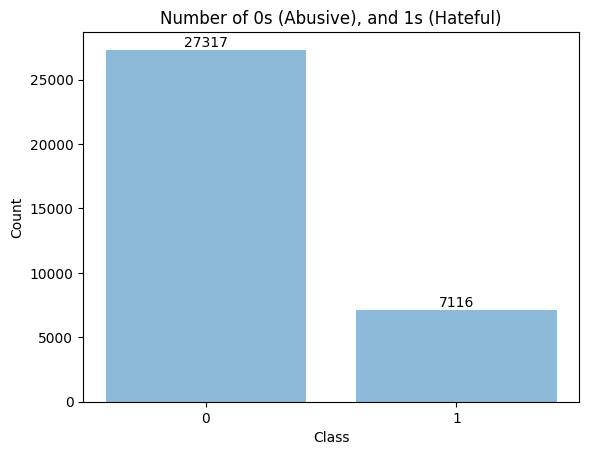

In [155]:
import matplotlib.pyplot as plt
import numpy as np


unique, counts = np.unique(original_hate_or_abusive_tweet_pred, return_counts=True)

plt.bar(unique, counts, align='center', alpha=0.5)
plt.xticks(unique, [str(x) for x in unique])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of 0s (Abusive), and 1s (Hateful)')

# Add text to show the count values
for i in range(len(unique)):
    plt.text(unique[i], counts[i], str(counts[i]), ha='center', va='bottom')

plt.show()

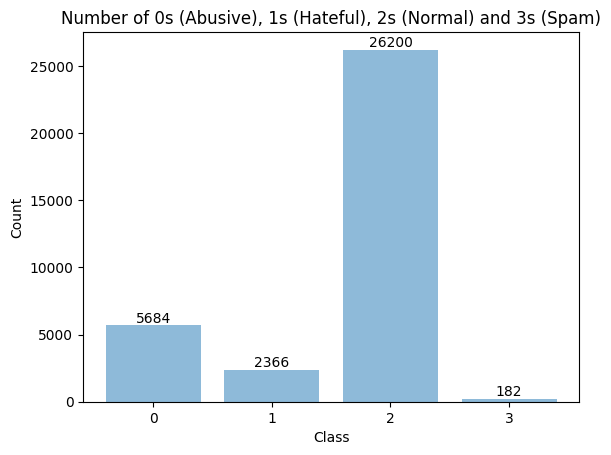

In [156]:
unique, counts = np.unique(abusive_or_hate_pred_after_replacement_pred, return_counts=True)

plt.bar(unique, counts, align='center', alpha=0.5)
plt.xticks(unique, [str(x) for x in unique])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of 0s (Abusive), 1s (Hateful), 2s (Normal) and 3s (Spam)')

# Add text to show the count values
for i in range(len(unique)):
    plt.text(unique[i], counts[i], str(counts[i]), ha='center', va='bottom')

plt.show()